# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import neurokit2 as nk
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import statsmodels.api as sm
import gc
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [20, 5] 

#  Biopac data 

## Combine data

In [3]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  

data_full = pd.DataFrame(columns=['Timestamp', 'Raw_EDA_biopac', 'Raw_ECG_biopac', 'EventLabel', 'Participant'])


for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv'): 
        data = pd.read_csv(file_path, comment='#',low_memory=False)
        if 'Channel 9 (EDA100C)' in data.columns:
            eda_column = 'Channel 9 (EDA100C)'
            ecg_column = 'Channel 13 (ECG100C)'
        elif 'Channel 9 (Raw)' in data.columns:
            eda_column = 'Channel 9 (Raw)'
            ecg_column = 'Channel 13 (Raw)'
        data = data[['Row', 'Timestamp', eda_column, ecg_column,'MarkerName','MarkerType']]
        start, end = data.query('MarkerName == "Experiment" and MarkerType == "S"').index.values[0], data.query('MarkerName == "Experiment" and MarkerType == "E"').index.values[0]
        data = data[start:end+1]
        data.reset_index(inplace=True, drop=True)
        markers =  list(data[data['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data[(data.MarkerName == m) & (data.MarkerType == "S")].index.values[0]
            end = data[(data.MarkerName == m) & (data.MarkerType == "E")].index.values[0]
            data.loc[start:end, 'EventLabel'] = data.loc[start:end, 'EventLabel'].fillna(m)
        #data['EventLabel'] = data['EventLabel'].fillna('Silence')

        non_nan_indices = data['EventLabel'].notna()
        first_non_nan = non_nan_indices.idxmax() 
        last_non_nan = non_nan_indices[::-1].idxmax()

        data.loc[:first_non_nan-1, 'EventLabel'] = data.loc[:first_non_nan-1, 'EventLabel'].fillna('first_silence')
        data.loc[last_non_nan+1:, 'EventLabel'] = data.loc[last_non_nan+1:, 'EventLabel'].fillna('last_silence')

        data.dropna(subset=[eda_column, ecg_column], inplace=True)
        data.drop(columns=['MarkerName', 'MarkerType', 'Row'], inplace=True)
        data['Participant'] = [filename.split('.')[0]] * len(data)
        data.rename(columns={eda_column: 'Raw_EDA_biopac', ecg_column:'Raw_ECG_biopac'}, inplace=True)
        data_full = pd.concat([data_full, data], ignore_index=True)
        del data
        gc.collect()
 

data_full

/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_49373/3198673846.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_full = pd.concat([data_full, data], ignore_index=True)


,Timestamp,Raw_EDA_biopac,Raw_ECG_biopac,EventLabel,Participant
0,10545.0005,1.191406,0.973206,first_silence,I8L4N6G7
1,10550.0005,1.192017,1.372375,first_silence,I8L4N6G7
2,10555.0005,1.191711,1.466064,first_silence,I8L4N6G7
3,10560.0005,1.192322,1.022949,first_silence,I8L4N6G7
4,10565.0005,1.192322,0.177612,first_silence,I8L4N6G7
...,...,...,...,...,...
3050935,933564.2909,1.839600,-0.037537,last_silence,K4G7Y9O2
3050936,933569.2909,1.841431,-0.045776,last_silence,K4G7Y9O2
3050937,933574.2909,1.839905,-0.041504,last_silence,K4G7Y9O2
3050938,933579.2909,1.840210,-0.043945,last_silence,K4G7Y9O2


In [4]:
len(data_full.Participant.unique())

17

In [5]:
data_full.Participant.value_counts()

Participant
V9L0P2K7    180004
N7P5B8G0    180002
J6W7Q4H5    180001
G9K4W1Z0    180000
Z6A2W1E8    180000
M4H6R2W9    180000
X5Q0G4J2    180000
J4X1T0D2    180000
C1K4L9S8    179999
D0P7X9W6    179997
M7D3F5K4    179997
O4A0U8R1    179997
K4G7Y9O2    179996
L0S1Z2I3    179994
U6O5V2T9    178371
I8L4N6G7    178046
M0R6U5F9    174536
Name: count, dtype: int64

In [6]:
data_full.EventLabel.value_counts() 

EventLabel
IntenseAudio     925101
CalmAudio        923501
first_silence    710911
last_silence     321176
InterimAudio     170251
Name: count, dtype: int64

In [ ]:
# data_full.to_csv('/Users/annapalatkina/Desktop/drive/driving_performance_project/notebooks/data_full_biopac.csv', index=False)

## Add filtering from Martins notebook to data_full

In [3]:
data_full = pd.read_csv('/Users/annapalatkina/Desktop/drive/driving_performance_project/notebooks/data_full_biopac.csv')

### ECG

In [4]:
ecg_folder = '/Users/annapalatkina/Desktop/drive/marimo_results/ECG'

ecg_data = {}
for filename in os.listdir(ecg_folder):
    if filename.endswith('.csv'):
        participant_id = filename.replace('.csv', '')
        df = pd.read_csv(os.path.join(ecg_folder, filename))
        ecg_data[participant_id] = df['Filtered'].values  

In [5]:
data_full['filtered_marimo_ECG'] = pd.Series(index=data_full.index, dtype=float)


for pid in data_full.Participant.unique():
    mask = data_full.Participant == pid
    data_full.loc[mask, 'filtered_marimo_ECG'] = ecg_data[pid]

data_full

,Timestamp,Raw_EDA_biopac,Raw_ECG_biopac,EventLabel,Participant,filtered_marimo_ECG
0,10545.0005,1.191406,0.973206,first_silence,I8L4N6G7,0.015040
1,10550.0005,1.192017,1.372375,first_silence,I8L4N6G7,0.050800
2,10555.0005,1.191711,1.466064,first_silence,I8L4N6G7,0.093014
3,10560.0005,1.192322,1.022949,first_silence,I8L4N6G7,0.128453
4,10565.0005,1.192322,0.177612,first_silence,I8L4N6G7,0.142824
...,...,...,...,...,...,...
3050935,933564.2909,1.839600,-0.037537,last_silence,K4G7Y9O2,-0.052084
3050936,933569.2909,1.841431,-0.045776,last_silence,K4G7Y9O2,-0.051126
3050937,933574.2909,1.839905,-0.041504,last_silence,K4G7Y9O2,-0.050258
3050938,933579.2909,1.840210,-0.043945,last_silence,K4G7Y9O2,-0.049387


### EDA

In [48]:
eda_folder = '/Users/annapalatkina/Desktop/drive/marimo_results/EDA_biopac'

eda_data = {}
for filename in os.listdir(eda_folder):
    if filename.endswith('.csv'):
        participant_id = filename.replace('.csv', '')
        df = pd.read_csv(os.path.join(eda_folder, filename))
        eda_data[participant_id] = df['Filtered'].values  

In [49]:
data_full['filtered_marimo_EDA'] = pd.Series(index=data_full.index, dtype=float)


for pid in data_full.Participant.unique():
    mask = data_full.Participant == pid
    data_full.loc[mask, 'filtered_marimo_EDA'] = eda_data[pid]

data_full

,Timestamp,Raw_EDA_biopac,Raw_ECG_biopac,EventLabel,Participant,filtered_marimo_ECG,filtered_marimo_EDA
0,10545.0005,1.191406,0.973206,first_silence,I8L4N6G7,0.015040,0.018412
1,10550.0005,1.192017,1.372375,first_silence,I8L4N6G7,0.050800,0.054648
2,10555.0005,1.191711,1.466064,first_silence,I8L4N6G7,0.093014,0.089709
3,10560.0005,1.192322,1.022949,first_silence,I8L4N6G7,0.128453,0.123633
4,10565.0005,1.192322,0.177612,first_silence,I8L4N6G7,0.142824,0.156459
...,...,...,...,...,...,...,...
3050935,933564.2909,1.839600,-0.037537,last_silence,K4G7Y9O2,-0.052084,0.005403
3050936,933569.2909,1.841431,-0.045776,last_silence,K4G7Y9O2,-0.051126,0.005395
3050937,933574.2909,1.839905,-0.041504,last_silence,K4G7Y9O2,-0.050258,0.005391
3050938,933579.2909,1.840210,-0.043945,last_silence,K4G7Y9O2,-0.049387,0.005368


In [50]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050940 entries, 0 to 3050939
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Timestamp            float64
 1   Raw_EDA_biopac       float64
 2   Raw_ECG_biopac       float64
 3   EventLabel           object 
 4   Participant          object 
 5   filtered_marimo_ECG  float64
 6   filtered_marimo_EDA  float64
dtypes: float64(5), object(2)
memory usage: 162.9+ MB


In [51]:
data_full.describe()

,Timestamp,Raw_EDA_biopac,Raw_ECG_biopac,filtered_marimo_ECG,filtered_marimo_EDA
count,3.050940e+06,3.050940e+06,3.050940e+06,3.050940e+06,3.050940e+06
mean,4.828329e+05,1.783122e+00,-1.785353e-02,-6.495165e-05,6.509816e-03
std,2.627810e+05,8.312880e-01,4.290701e-01,1.024652e-01,1.051352e-01
min,5.139477e+03,-4.693909e+00,-8.060608e+00,-1.259863e+00,-1.629279e+00
25%,2.584331e+05,1.417236e+00,-1.867676e-01,-5.353591e-02,-1.626919e-02
50%,4.827675e+05,1.696167e+00,-5.401611e-02,-1.362993e-02,-4.889206e-03
75%,7.071020e+05,2.197571e+00,6.469727e-02,3.891501e-02,3.726900e-03
max,1.089257e+06,4.915466e+00,5.371399e+00,2.420955e+00,3.366819e+00


In [52]:
data_full.to_csv('data_full_with_marimo_filtered.csv',index=False)

## Split conditions

In [230]:
data_full = pd.read_csv('data_full_with_marimo_filtered.csv')

In [231]:
mask_silence_first = (data_full["EventLabel"] == "first_silence")
mask_silence_last = (data_full["EventLabel"] == "last_silence")
mask_negative = (data_full["EventLabel"] == "IntenseAudio")
mask_positive = (data_full["EventLabel"] == "CalmAudio")
mask_music = (data_full["EventLabel"] == "InterimAudio")

In [232]:
positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines_first = data_full[mask_silence_first]
baselines_last = data_full[mask_silence_last]

## ECG

In [8]:
sampling_rate = 200

### HRV PLOTS

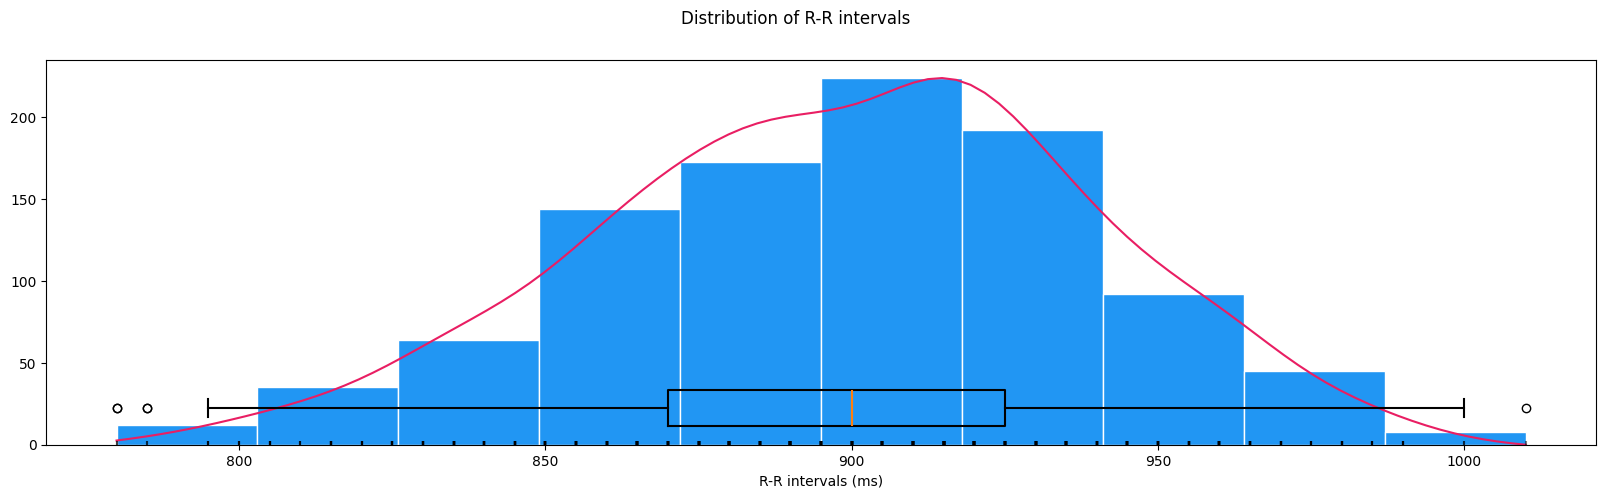

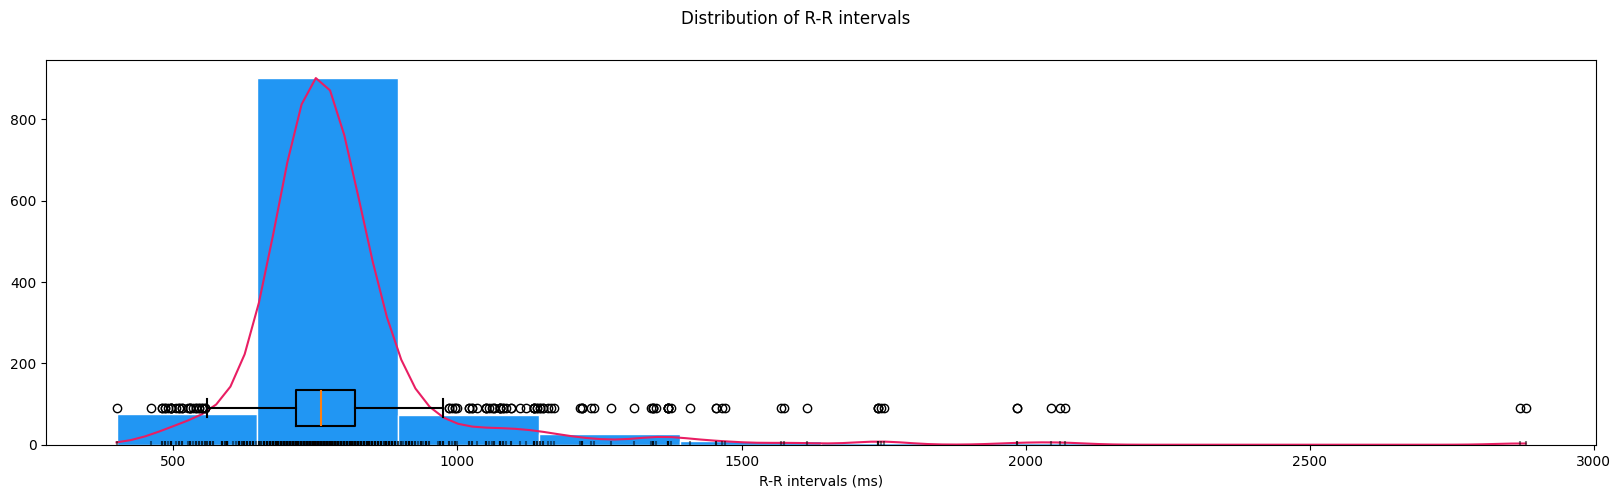

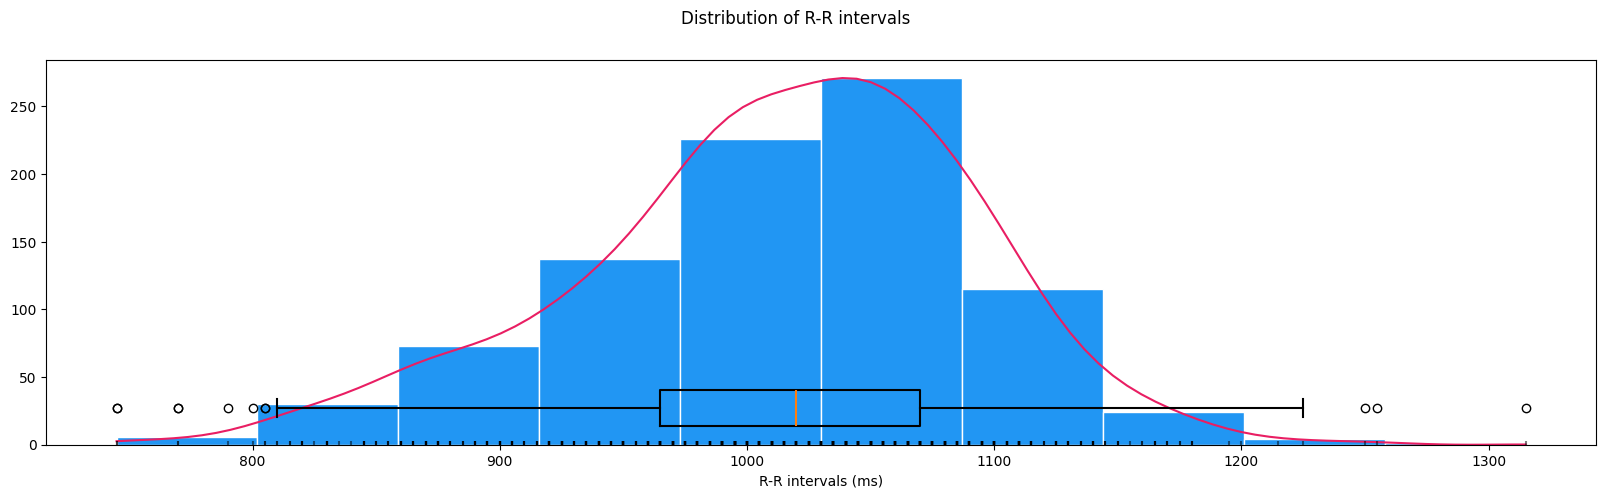

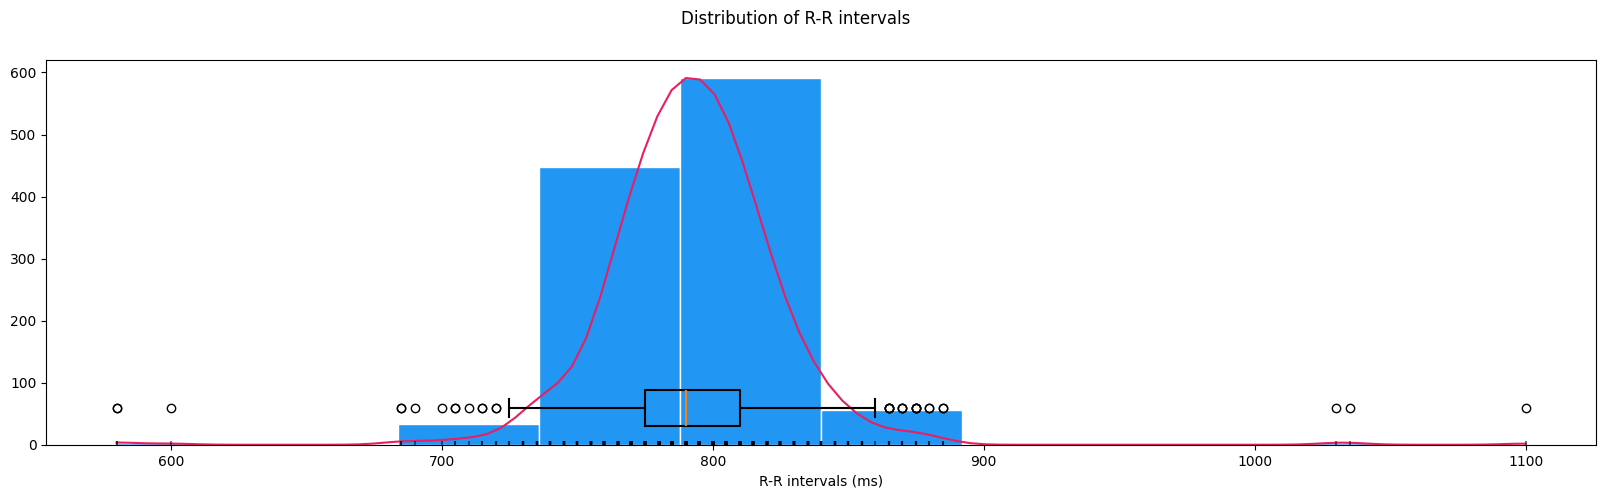

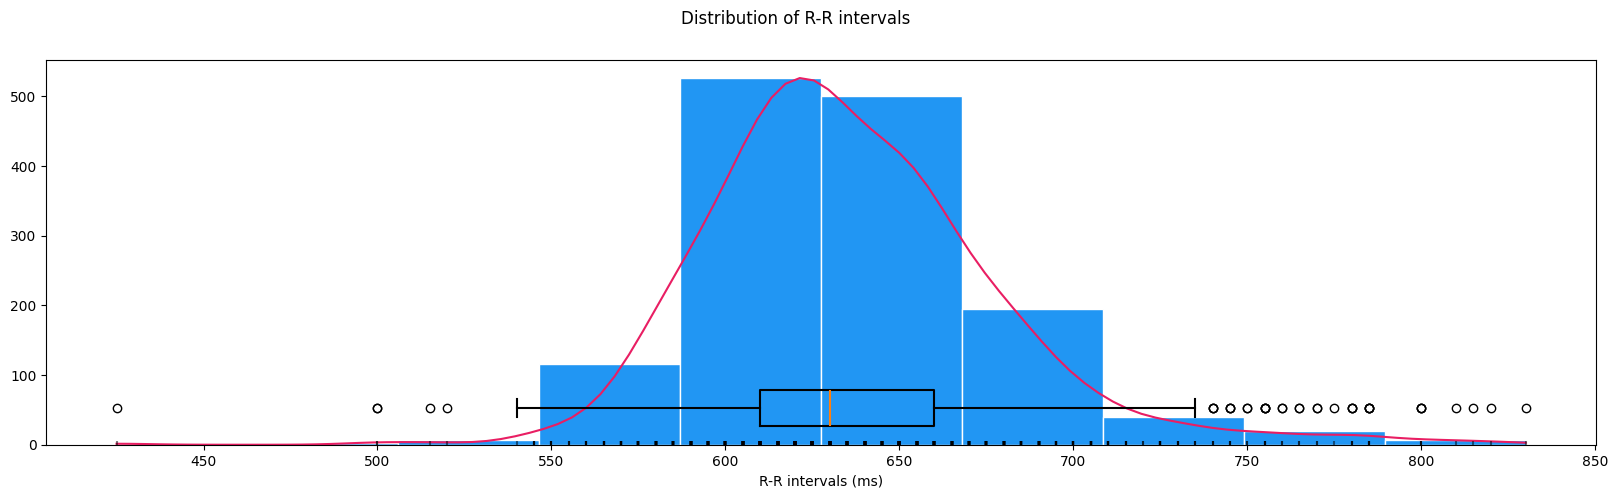

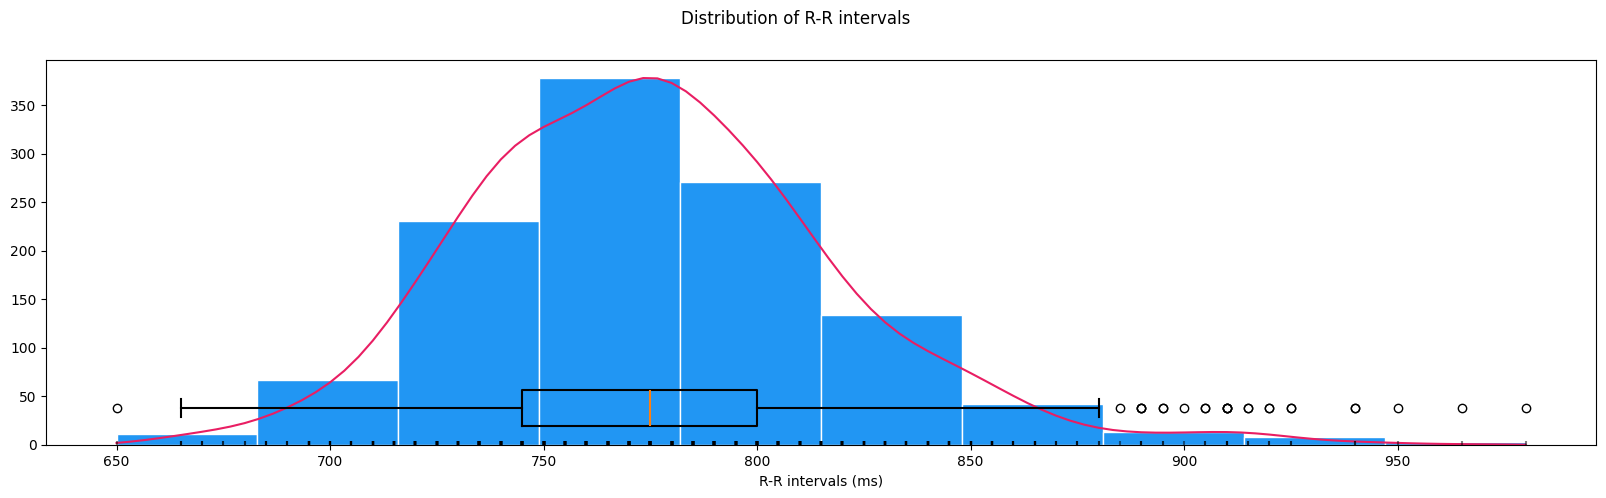

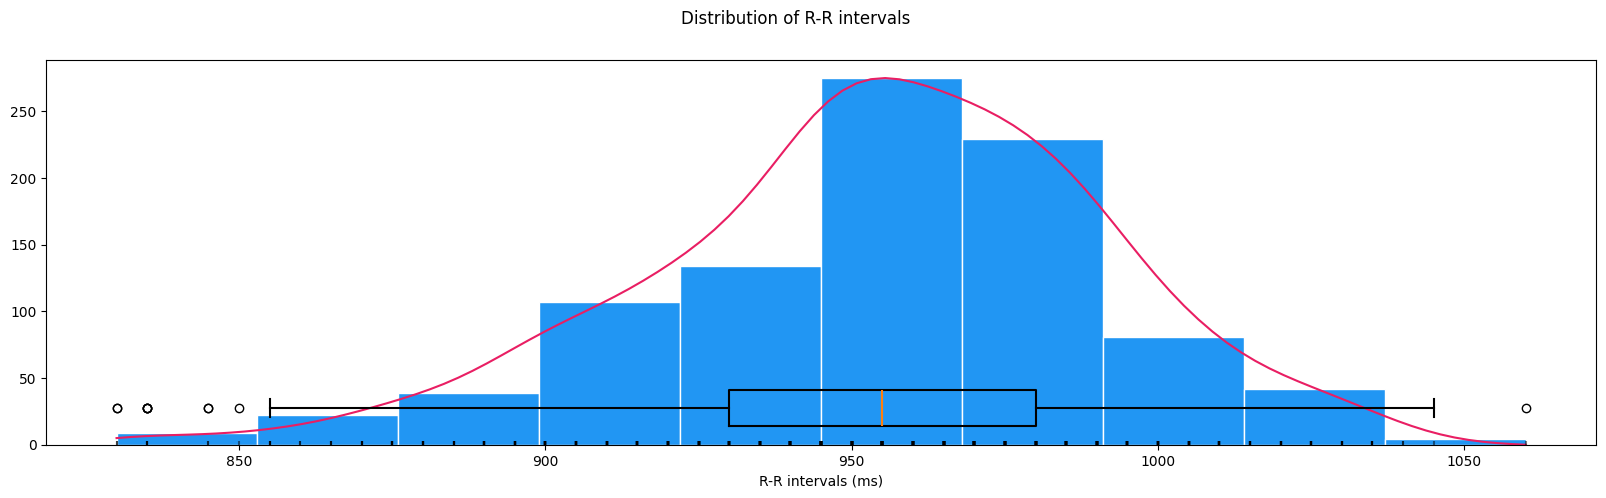

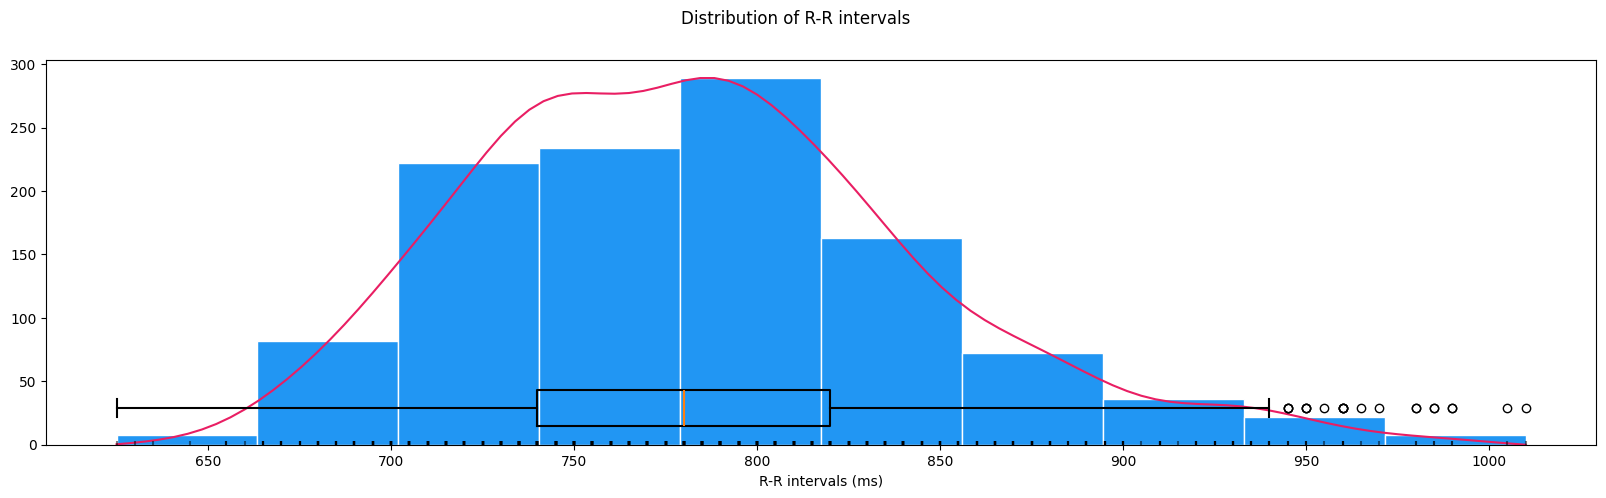

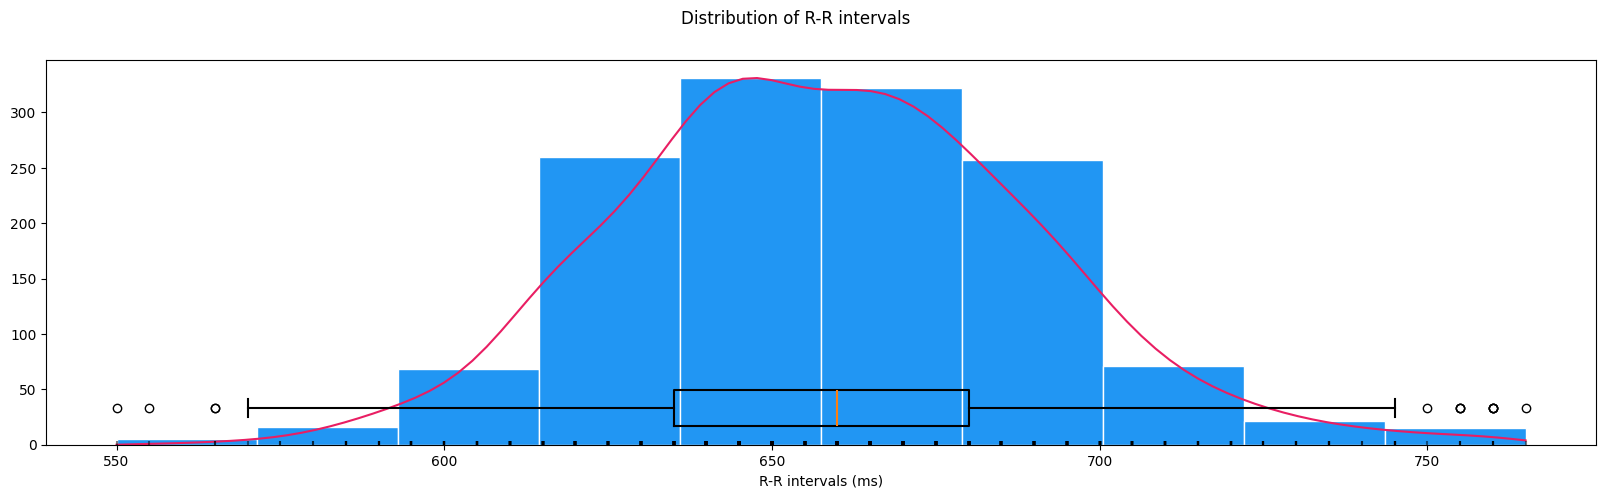

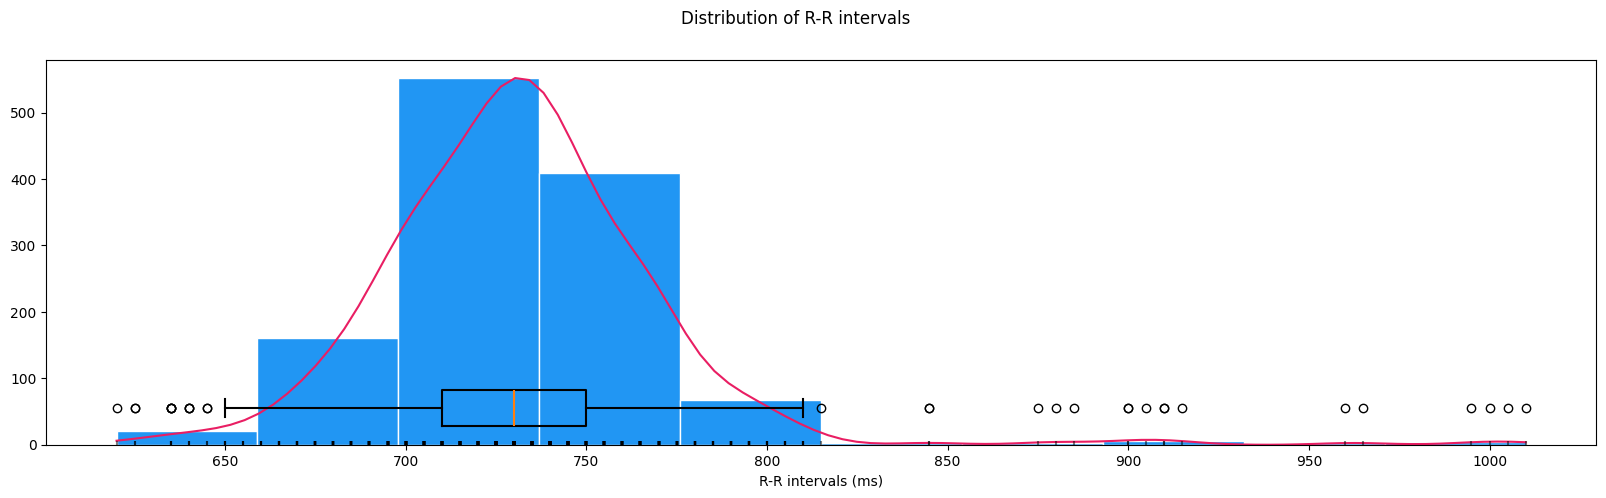

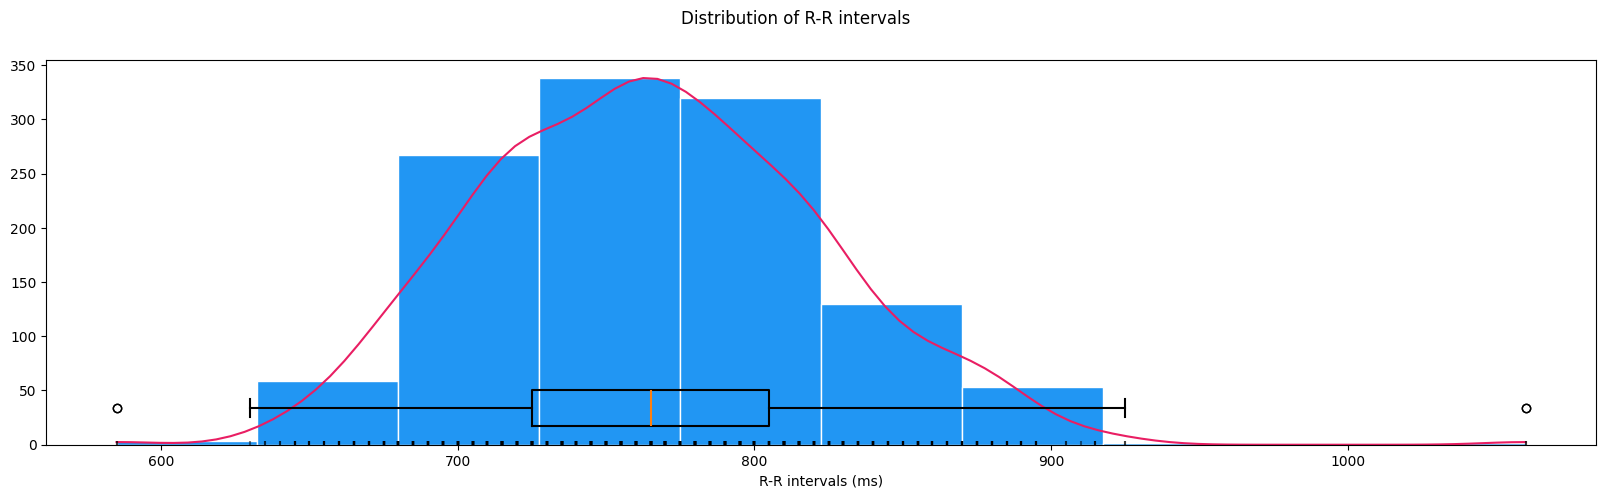

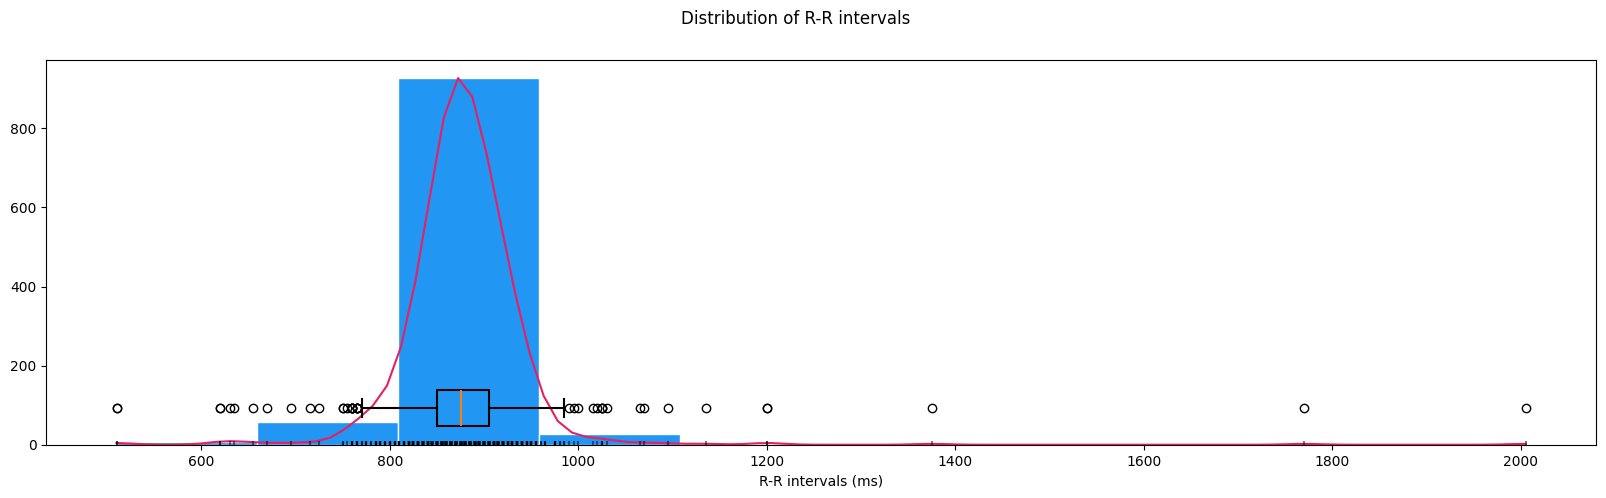

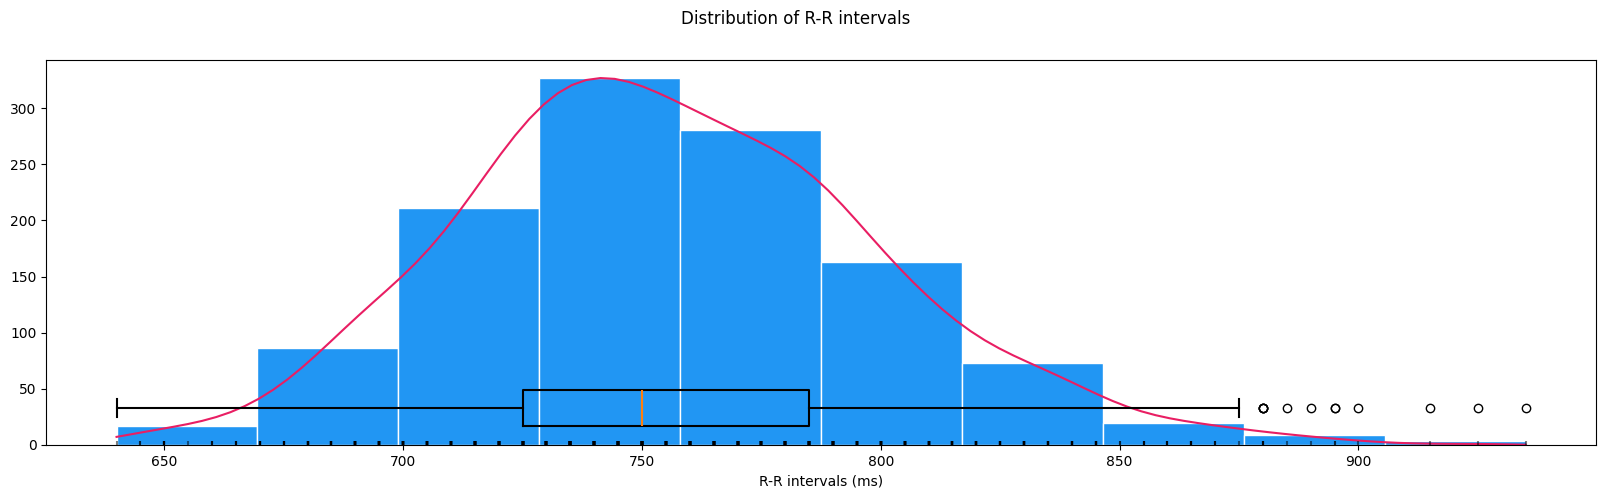

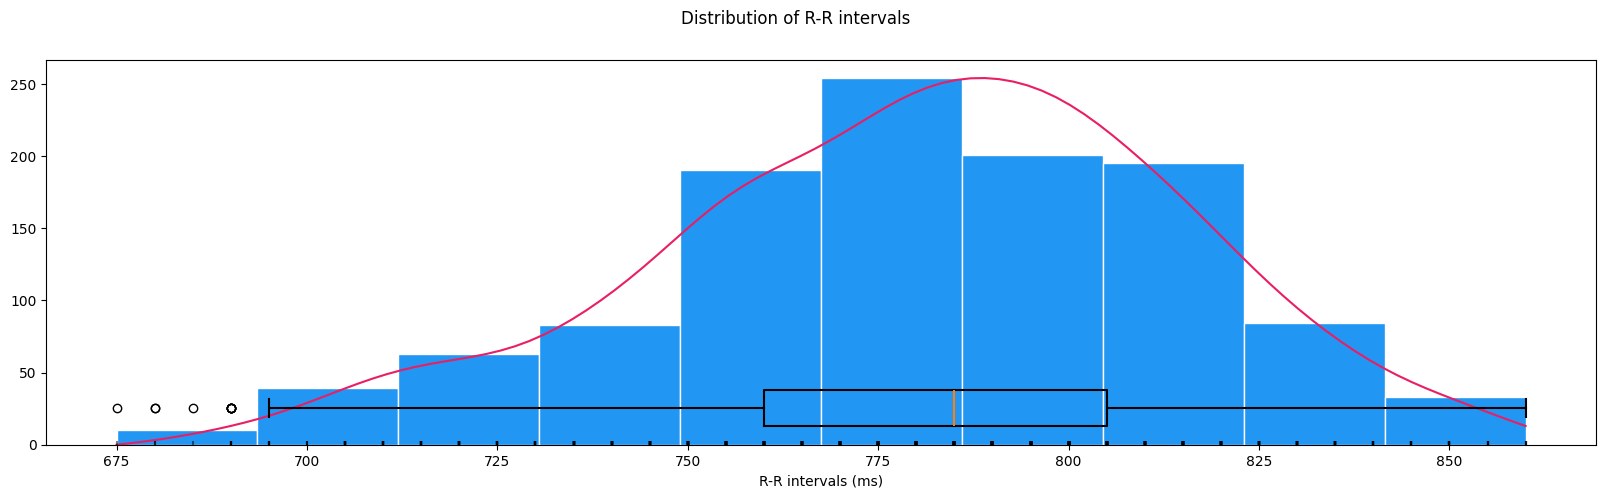

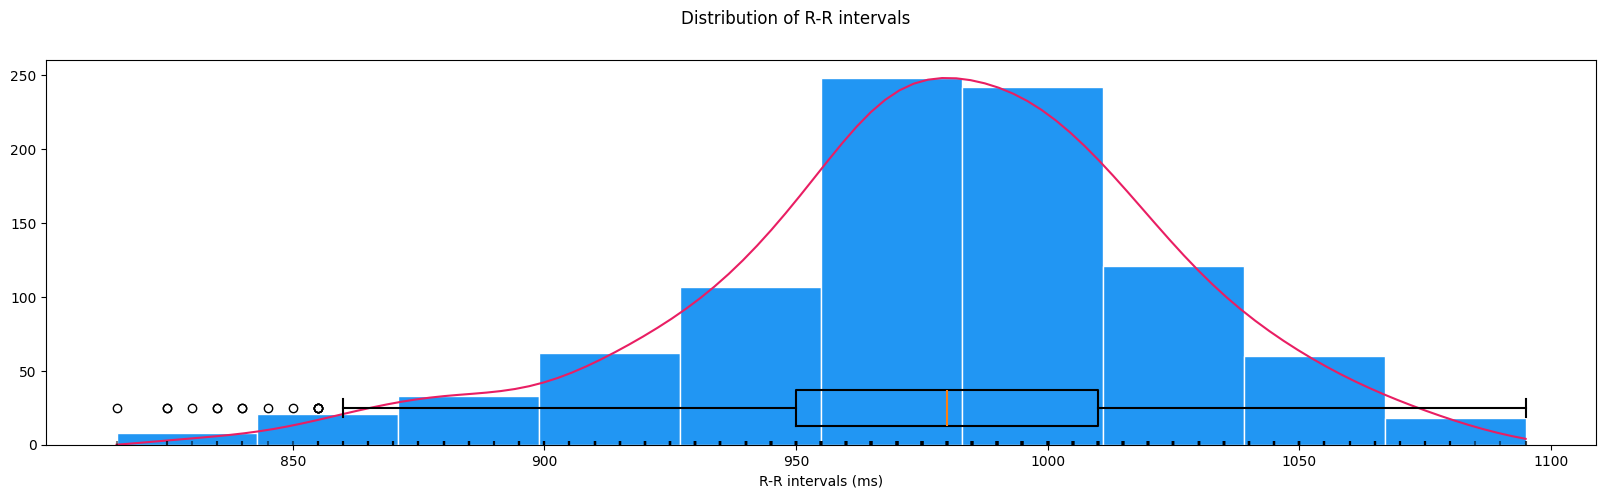

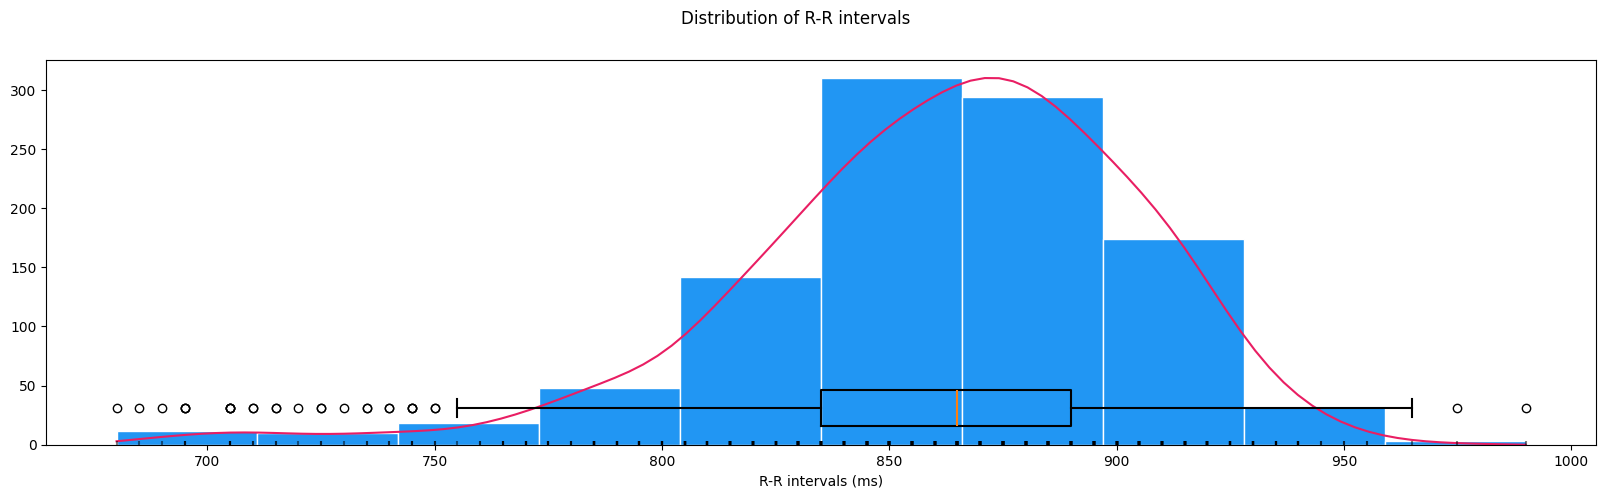

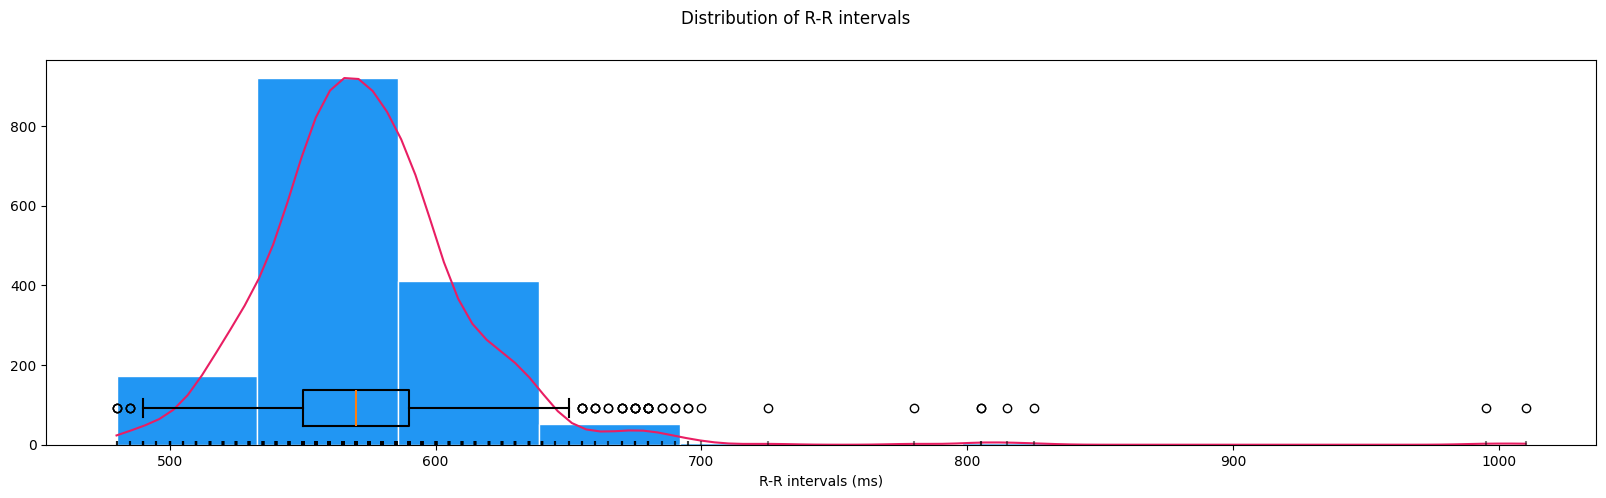

In [16]:
hrv_df_full = pd.DataFrame()

for pid in data_full.Participant.unique():
    peaks, info = nk.ecg_peaks(data_full.query('Participant == @pid').filtered_marimo_ECG, sampling_rate=sampling_rate, correct_artifacts=True)
    hrv = nk.hrv_time(peaks, sampling_rate=sampling_rate, show=True)
    hrv['Participant'] = pid
    hrv_df_full = pd.concat([hrv_df_full, hrv], ignore_index=True)


In [ ]:
#hrv_df_full.to_csv('hrv_df_full.csv', index=False)

In [18]:
hrv_df_full

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,Participant
0,898.918099,41.000177,25.564084,32.413309,22.963795,35.269814,19.134753,37.920227,33.003343,33.019902,...,1.242304,865.0,935.0,7.280081,65.116279,780.0,1010.0,8.830357,140.6250,I8L4N6G7
1,795.826484,195.555803,71.248864,160.578712,69.171215,163.028373,49.153959,173.418009,155.856937,155.928218,...,1.254714,705.0,831.0,24.018265,48.675799,400.0,2880.0,14.600000,0.0000,M0R6U5F9
2,1012.694476,80.417647,36.371386,71.437948,27.925159,75.188646,17.092390,78.798218,70.367465,70.406882,...,1.142824,950.0,1080.0,45.546787,74.633596,745.0,1315.0,16.127273,296.8750,D0P7X9W6
3,792.597002,32.690164,14.205129,27.387770,9.259870,26.871088,9.935435,31.594620,30.685030,30.698499,...,1.065346,770.0,815.0,3.791887,40.123457,580.0,1100.0,6.831325,0.0000,M7D3F5K4
4,635.792079,41.686092,14.151956,38.129637,8.145896,40.766577,3.712695,41.182943,25.857892,25.866678,...,1.612123,605.0,665.0,3.748232,20.579915,425.0,830.0,8.782609,0.0000,O4A0U8R1
5,775.967185,43.976075,15.048674,40.091164,12.245553,40.021068,4.235196,43.678964,26.132929,26.144217,...,1.682784,740.0,808.0,3.195164,31.692573,650.0,980.0,9.338710,125.0000,V9L0P2K7
6,954.214437,37.511156,19.731862,31.192203,19.211613,31.638559,19.857299,33.005726,22.061045,22.072161,...,1.700335,925.0,985.0,2.335456,28.131635,830.0,1060.0,8.486486,125.0000,M4H6R2W9
7,784.075704,63.266651,33.909147,53.942318,27.896704,57.927234,12.105405,62.468060,49.841378,49.863306,...,1.269360,730.0,830.0,23.767606,58.010563,625.0,1010.0,13.686747,164.0625,U6O5V2T9
8,658.239385,31.877636,14.824431,28.160155,12.783738,29.720563,8.992285,30.818087,14.646631,14.651896,...,2.176448,630.0,685.0,0.366032,11.713031,550.0,765.0,8.179641,0.0000,G9K4W1Z0
9,732.027687,39.189539,10.379636,36.016226,8.716465,38.312891,2.215101,38.794348,27.282518,27.293598,...,1.436434,705.0,755.0,2.605863,27.850163,620.0,1010.0,7.675000,0.0000,N7P5B8G0


### Signal quality check

In [ ]:
hrv_df_full = pd.DataFrame()

for pid in data_full.Participant.unique():
    peaks, info = nk.ecg_peaks(data_full.query('Participant == @pid').filtered_marimo_ECG, sampling_rate=sampling_rate, correct_artifacts=True)
    hrv = nk.hrv_time(peaks, sampling_rate=sampling_rate, show=True)
    hrv['Participant'] = pid
    hrv_df_full = pd.concat([hrv_df_full, hrv], ignore_index=True)


In [39]:
d = []

for pid in data_full.Participant.unique():
    s = data_full.query('Participant == @pid').filtered_marimo_ECG
    quality = nk.ecg_quality(s, sampling_rate=sampling_rate)
    d_new = {'Participant':[pid]*len(quality), 'quality':quality}
    d.append(d_new)

df = pd.DataFrame(d)  
df_exploded = df.explode(['Participant', 'quality']).reset_index(drop=True)

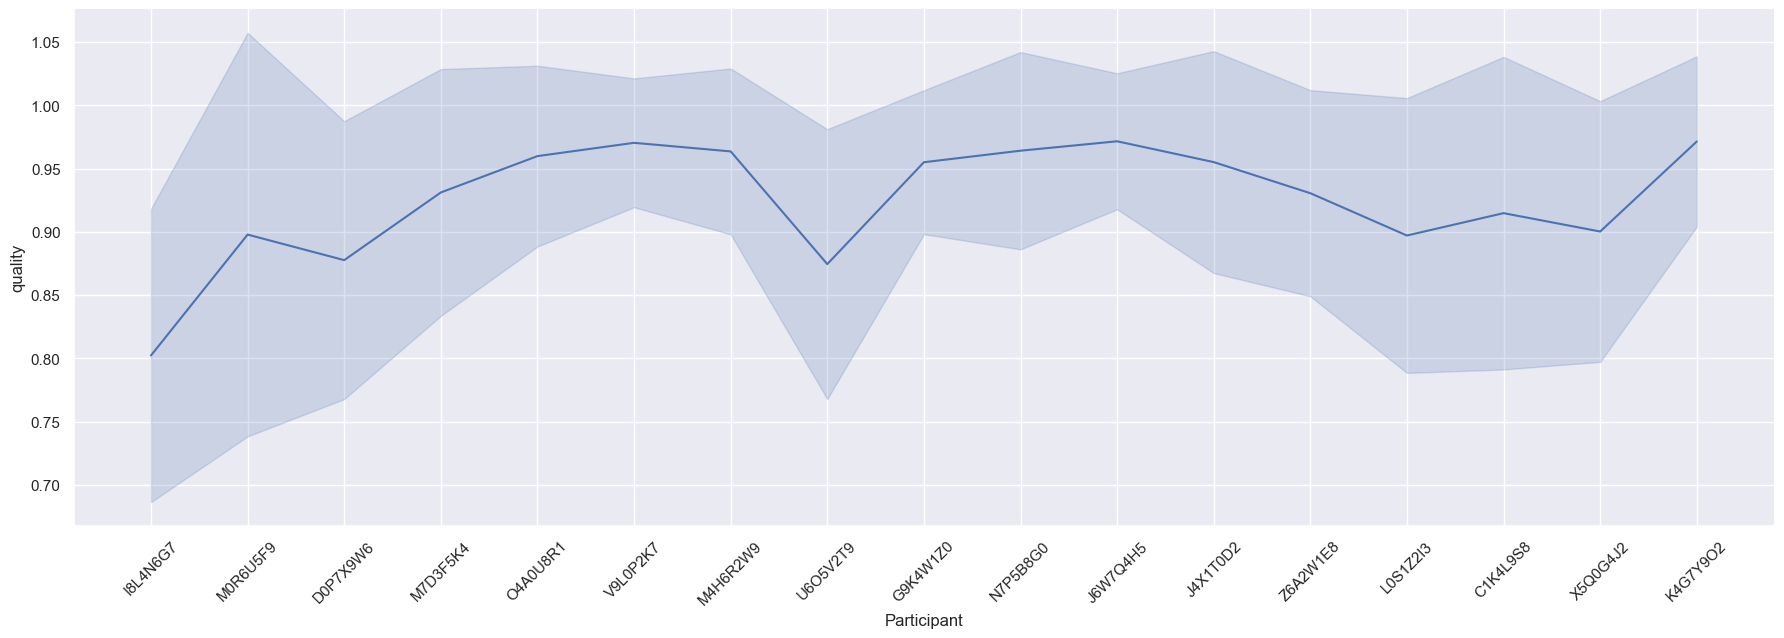

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.relplot(data=df_exploded, x="Participant", y="quality", kind="line", errorbar='sd', height=6, aspect=3 )
plt.xticks(rotation=45)
plt.show()

### Statistical tests

In [19]:
def get_slope_for_condition(ecg, segment_duration):
    
    peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate, correct_artifacts=True)
    r_peaks = info['ECG_R_Peaks']
    #segment_duration = 60  # For 1-minute segments (use 30 for 30-second segments)

    # Step 1: Convert R-peak indices to time (seconds)
    times = np.array(r_peaks) / sampling_rate

    # Step 2: Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(times) * 1000  # Difference in seconds, then convert to ms

    # Step 3: Segment the data
    total_duration = times[-1]  # Total experiment time in seconds
    num_segments = int(np.floor(total_duration / segment_duration))
    # print(total_duration, num_segments)

    rmssd_per_segment = []
    time_list = []

    for seg in range(num_segments):
        # Define the time window for this segment
        start_time = seg * segment_duration
        end_time = (seg + 1) * segment_duration
        
        # Find R-peaks within this time window
        mask = (times[:-1] >= start_time) & (times[:-1] < end_time)
        segment_rr = rr_intervals[mask]
        
        # Step 4: Calculate RMSSD for this segment
        successive_diffs = np.diff(segment_rr)
        squared_diffs = successive_diffs ** 2
        mean_squared_diffs = np.mean(squared_diffs)
        rmssd = np.sqrt(mean_squared_diffs)
        rmssd_per_segment.append(rmssd)
        time_list.append(end_time)
    
    # print(len(time_list), len(rmssd_per_segment))
    #rmssd_df = pd.DataFrame({'Time': time_list, 'RMSSD': rmssd_per_segment})
    #rmssd_df['Time_str'] = rmssd_df['Time'].apply(lambda x: str(timedelta(seconds=x)))

    X = sm.add_constant(time_list)
    model = sm.OLS(rmssd_per_segment, X).fit()
    slope = model.params[1]

    return slope

In [40]:
# check if my functions works, check with nk.hrv_time()['HRV_RMSSD']

ecg = data_full.query('Participant == "M7D3F5K4"').filtered_marimo_ECG
segment_duration = 899

peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate, correct_artifacts=True)
r_peaks = info['ECG_R_Peaks']
#segment_duration = 60  # For 1-minute segments (use 30 for 30-second segments)

# Step 1: Convert R-peak indices to time (seconds)
times = np.array(r_peaks) / sampling_rate

# Step 2: Calculate RR intervals (in milliseconds)
rr_intervals = np.diff(times) * 1000  # Difference in seconds, then convert to ms

# Step 3: Segment the data
total_duration = times[-1]  # Total experiment time in seconds


num_segments = int(np.floor(total_duration / segment_duration))

rmssd_per_segment = []
time_list = []

for seg in range(num_segments):
    # Define the time window for this segment
    start_time = seg * segment_duration
    end_time = (seg + 1) * segment_duration
    
    # Find R-peaks within this time window
    mask = (times[:-1] >= start_time) & (times[:-1] < end_time)
    segment_rr = rr_intervals[mask]
    
    # Step 4: Calculate RMSSD for this segment
    successive_diffs = np.diff(segment_rr)
    squared_diffs = successive_diffs ** 2
    mean_squared_diffs = np.mean(squared_diffs)
    rmssd = np.sqrt(mean_squared_diffs)
    rmssd_per_segment.append(rmssd)
    time_list.append(end_time)

peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate, correct_artifacts=True)
hrv = nk.hrv_time(peaks, sampling_rate=sampling_rate)


assert round(rmssd_per_segment[0],3) == round(hrv['HRV_RMSSD'].values[0],3)
# values typically range from 20-50 milliseconds for healthy adults
print(round(rmssd_per_segment[0],3))

30.685


In [26]:
segment_duration = 30


positives_slopes = [get_slope_for_condition(data.filtered_marimo_ECG, segment_duration) for participant_id, data in positives.groupby(by='Participant')]
negatives_slopes = [get_slope_for_condition(data.filtered_marimo_ECG, segment_duration) for participant_id, data in negatives.groupby(by='Participant')]
baselines_slopes_fisrt = [get_slope_for_condition(data.filtered_marimo_ECG, segment_duration) for participant_id, data in baselines_first.groupby(by='Participant')]
baselines_slopes_last = [get_slope_for_condition(data.filtered_marimo_ECG, segment_duration) for participant_id, data in baselines_last.groupby(by='Participant')]

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


t = [i for i, _  in positives.groupby(by='Participant')]

# Create a tidy DataFrame
df = pd.DataFrame({
    "Participant": t * 4,
    "Slope": list(positives_slopes) + list(negatives_slopes) + list(baselines_slopes_fisrt) + list(baselines_slopes_last),
    "Condition": ["Positive podcast"] * len(t) + ["Negative podcast"] * len(t) + ["Baseline silence"] * len(t) + ["Cool down phase"] * len(t)
})


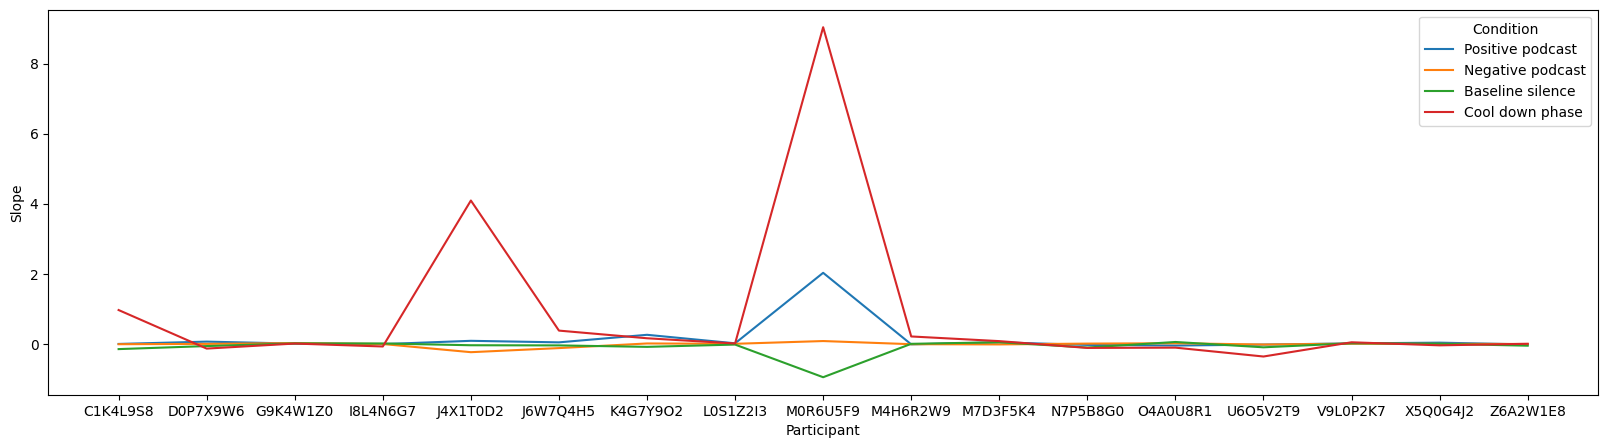

In [28]:
plt.rcParams['figure.figsize'] = [20, 5] 
sns.lineplot(data=df, x="Participant", y="Slope", hue="Condition")
plt.show()

In [29]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6] 


np.random.seed(42)  # For reproducibility
n_participants = len(baselines_slopes_fisrt)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline silence': baselines_slopes_fisrt,  
    'Cool down phase': baselines_slopes_last,  
    'Positive podcast': positives_slopes,
    'Negative podcast': negatives_slopes
}
df = pd.DataFrame(data)

# Long format for repeated measures ANOVA
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')
ps = []

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    ps.append(p >= 0.05)
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

print()


conditions = df.columns[1:]
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        cond1, cond2 = conditions[i], conditions[j]
        stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
        print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}")



Shapiro-Wilk test for Baseline silence: statistic=0.489, p=0.000
  Baseline silence is not normally distributed (p < 0.05)
Shapiro-Wilk test for Cool down phase: statistic=0.480, p=0.000
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.366, p=0.000
  Positive podcast is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative podcast: statistic=0.670, p=0.000
  Negative podcast is not normally distributed (p < 0.05)

Wilcoxon Baseline silence vs Cool down phase: statistic=49.000, p=0.207
Wilcoxon Baseline silence vs Positive podcast: statistic=27.000, p=0.017
Wilcoxon Baseline silence vs Negative podcast: statistic=56.000, p=0.353
Wilcoxon Cool down phase vs Positive podcast: statistic=67.000, p=0.678
Wilcoxon Cool down phase vs Negative podcast: statistic=54.000, p=0.306
Wilcoxon Positive podcast vs Negative podcast: statistic=42.000, p=0.109


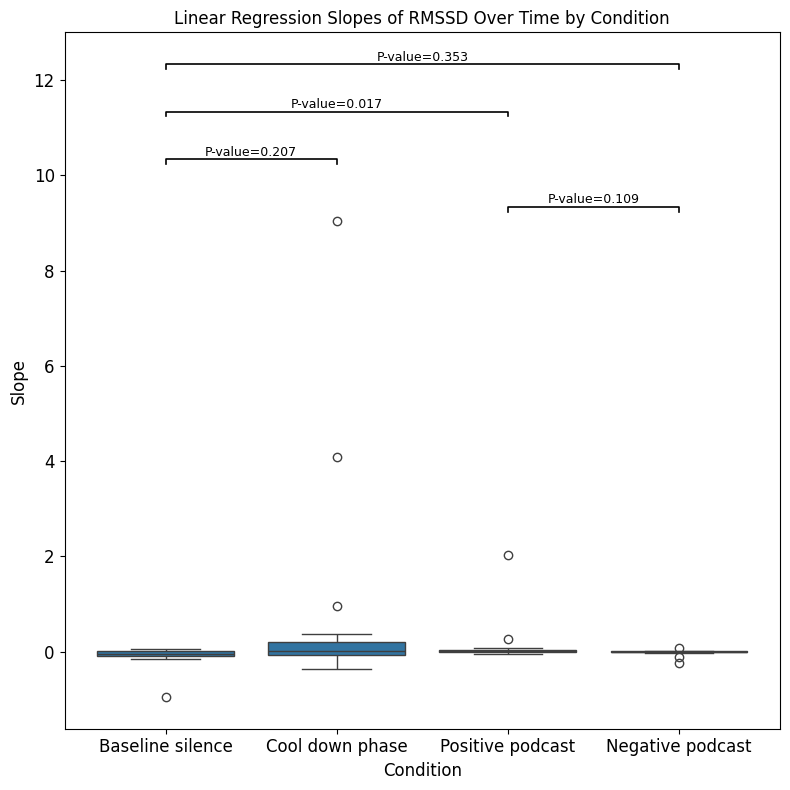

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon


# Melt data to long format
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')

# Initialize plot
plt.figure(figsize=(8, 8))
sns.boxplot(x='Condition', y='Slope', data=df_long)


comparisons = [
    ('Positive podcast', 'Negative podcast'),
    ('Baseline silence', 'Cool down phase'),
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
]


x_labels = df_long['Condition'].unique().tolist()


y_offset = 1
y_start = df_long['Slope'].max() + 0.2  # Leave space above highest point
h = 0.1  # Height of bracket
fontsize = 9


for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # Text label
    label =  f'P-value={round(p_val,3)}'
    plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Linear Regression Slopes of RMSSD Over Time by Condition', fontsize=12)
plt.ylabel('Slope', fontsize=12)
plt.xlabel('Condition', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## EDA biopac

In [53]:
sampling_rate = 200

### Some visualizations

In [88]:
plt.rcParams['figure.figsize'] = [20, 8] 

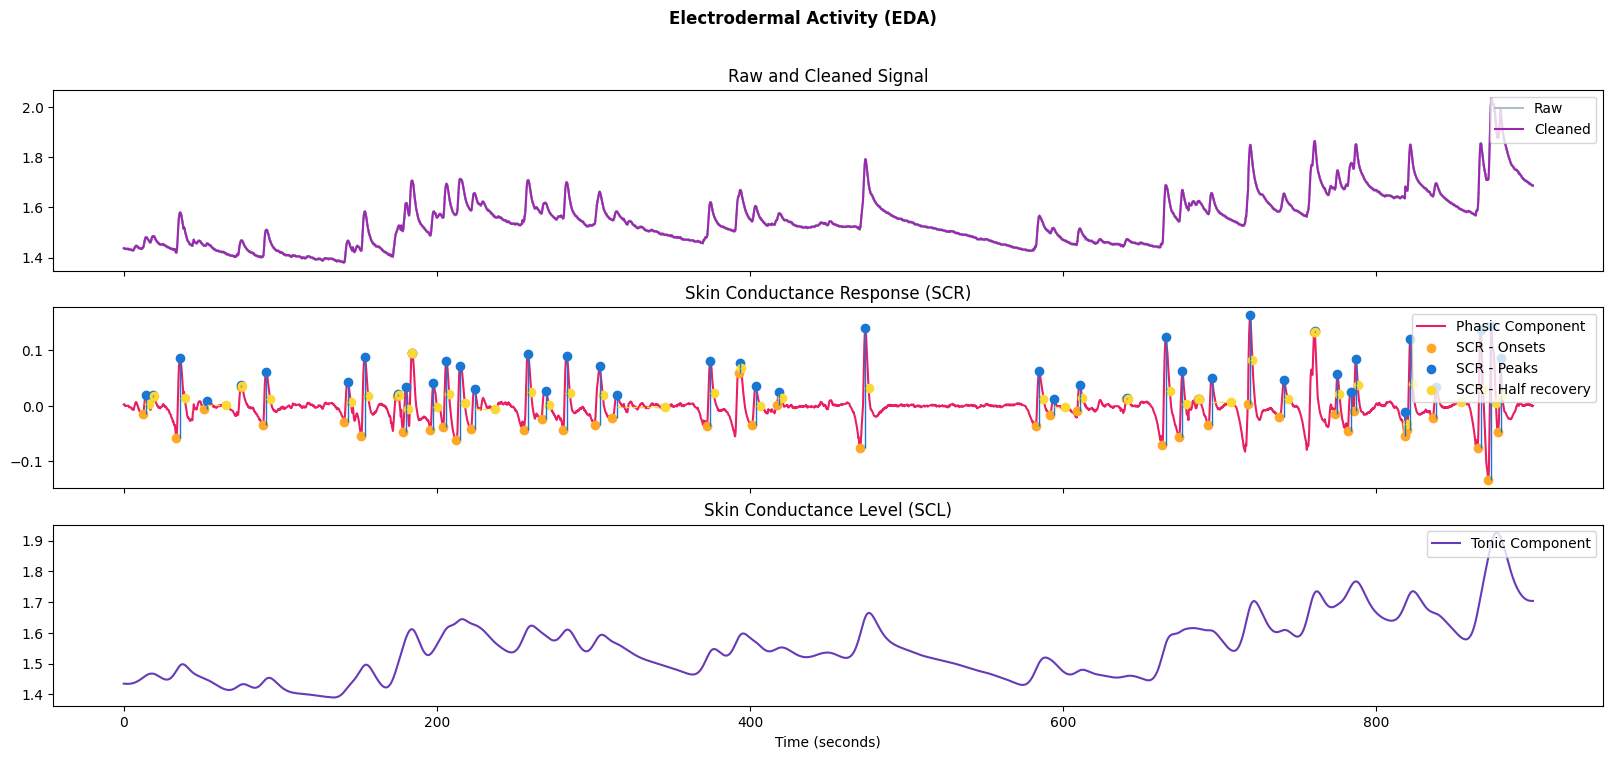

In [94]:
eda_signal = data_full.query('Participant == "C1K4L9S8"').Raw_EDA_biopac
signals, info = nk.eda_process(eda_signal, sampling_rate=sampling_rate)
nk.eda_plot(signals, info)

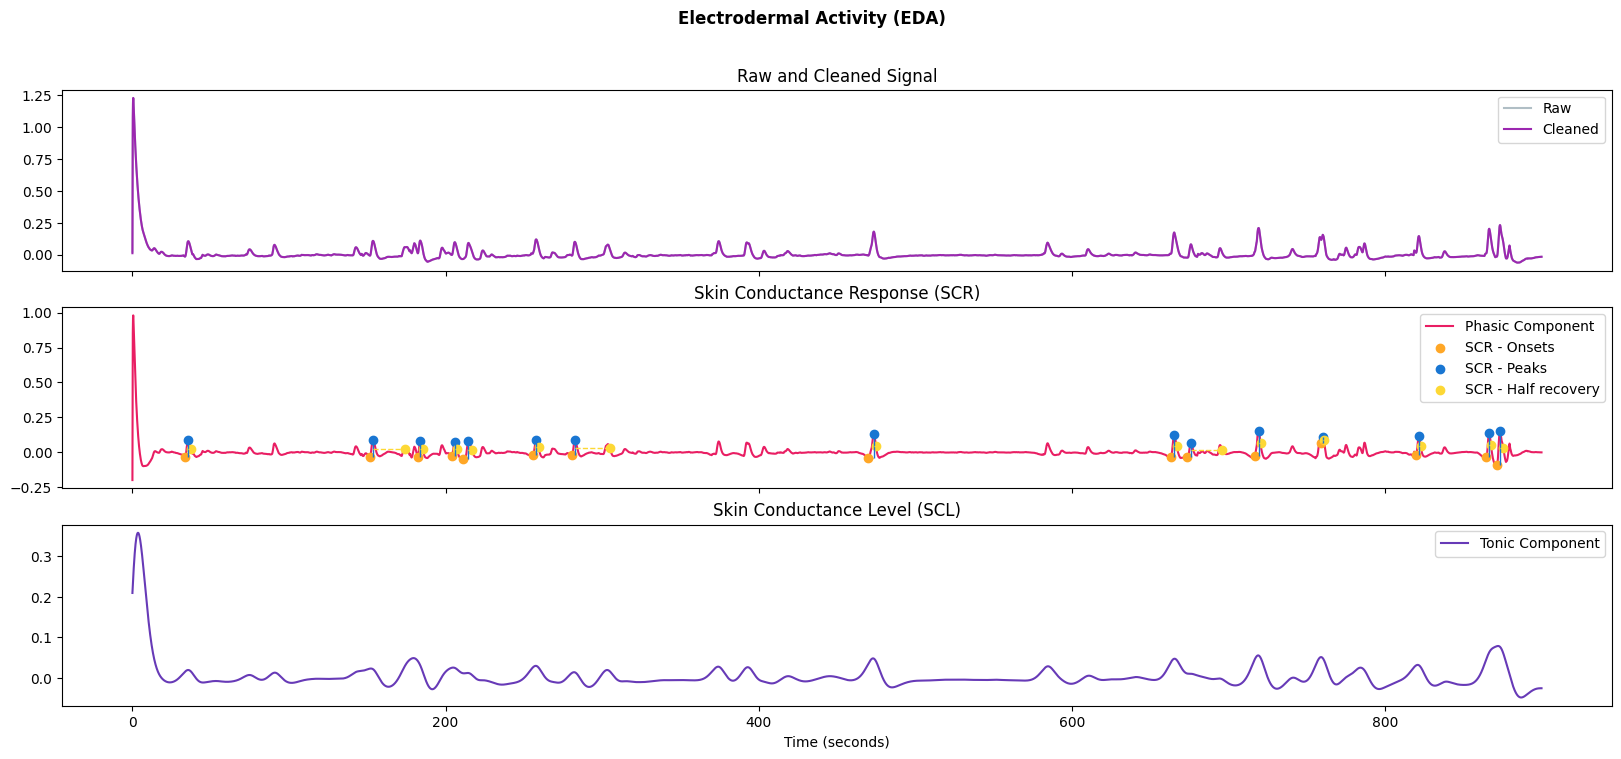

In [93]:
eda_signal = data_full.query('Participant == "C1K4L9S8"').filtered_marimo_EDA
signals, info = nk.eda_process(eda_signal, sampling_rate=sampling_rate)
nk.eda_plot(signals, info)

In [98]:
ecg_metrics = pd.DataFrame()

for participant, data in data_full.groupby(by='Participant'):
    signal, _= nk.eda_process(data.filtered_marimo_EDA, sampling_rate=sampling_rate)
    d = nk.eda_intervalrelated(signal, sampling_rate=sampling_rate)
    d['Participant'] = participant
    ecg_metrics = pd.concat([ecg_metrics, d], ignore_index=True)
    
ecg_metrics

/Users/annapalatkina/Desktop/drive/.venv/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/annapalatkina/Desktop/drive/.venv/lib/python3.10/site-packages/neurokit2/eda/eda_intervalrelated.py:120: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)


,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,EDA_Sympathetic,EDA_SympatheticN,EDA_Autocorrelation,Participant
0,16.0,0.132965,0.035704,0.000652,0.083472,0.223753,C1K4L9S8
1,8.0,0.213581,0.046565,0.000648,0.052839,0.276640,D0P7X9W6
2,34.0,0.467808,0.096121,0.010441,0.108897,0.122649,G9K4W1Z0
3,4.0,0.059184,0.026491,0.000152,0.034112,0.264240,I8L4N6G7
4,4.0,1.152519,0.049947,0.003431,0.146769,0.007699,J4X1T0D2
5,3.0,0.083442,0.018152,0.000028,0.037730,0.279089,J6W7Q4H5
6,1.0,NaN,0.041988,0.000065,0.022052,0.292241,K4G7Y9O2
7,80.0,0.272383,0.059227,0.008224,0.099724,0.022904,L0S1Z2I3
8,10.0,0.733752,0.056733,0.009134,0.115704,-0.055438,M0R6U5F9
9,9.0,0.030315,0.008988,0.000038,0.066117,0.254493,M4H6R2W9


In [92]:
ecg_metrics = pd.DataFrame()

for participant, data in data_full.groupby(by='Participant'):
    signal, _= nk.eda_process(data.Raw_EDA_biopac, sampling_rate=sampling_rate)
    d = nk.eda_intervalrelated(signal, sampling_rate=sampling_rate)
    d['Participant'] = participant
    ecg_metrics = pd.concat([ecg_metrics, d], ignore_index=True)

ecg_metrics

,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,EDA_Sympathetic,EDA_SympatheticN,EDA_Autocorrelation,Participant
0,45.0,0.085482,0.099033,0.000897,0.007311,0.838275,C1K4L9S8
1,18.0,0.145322,0.145362,0.000963,0.005761,0.851736,D0P7X9W6
2,70.0,0.357063,0.170303,0.013738,0.019515,0.465256,G9K4W1Z0
3,11.0,0.054471,0.173837,0.000253,0.003052,0.975580,I8L4N6G7
4,4.0,1.068565,0.157033,0.004428,0.020897,0.571210,J4X1T0D2
5,13.0,0.021988,0.079729,0.000045,0.001477,0.954714,J6W7Q4H5
6,52.0,0.016810,0.032927,0.000100,0.000577,0.814706,K4G7Y9O2
7,124.0,0.245572,0.204090,0.011202,0.036305,0.651558,L0S1Z2I3
8,12.0,0.528598,0.139766,0.011322,0.035059,0.349421,M0R6U5F9
9,25.0,0.007944,0.027752,0.000062,0.008048,0.870292,M4H6R2W9


### Statistical tests

In [ ]:
# Normalize by minutes!!

In [160]:
result = data_full.groupby(['EventLabel', 'Participant'])['Timestamp'].agg(['count'])
result

count
EventLabel   Participant       
CalmAudio    C1K4L9S8     54338
             D0P7X9W6     54406
             G9K4W1Z0     54200
             I8L4N6G7     54418
             J4X1T0D2     54200
...                         ...
last_silence O4A0U8R1     19156
             U6O5V2T9     17476
             V9L0P2K7     19159
             X5Q0G4J2     19147
             Z6A2W1E8     19600

[85 rows x 1 columns]

In [ ]:
average_time = result.groupby('EventLabel')['count'].mean() / 200 / 60
average_time

EventLabel
CalmAudio        4.526966
IntenseAudio     4.534809
InterimAudio     0.834564
first_silence    3.484858
last_silence     1.574392
Name: count, dtype: float64

In [ ]:
def extract_eda_info(df):
    n_peaks = []
    ampl_peaks = []

    for participant, data in df.groupby(by='Participant'):
        # signal, _= nk.eda_process(data.filtered_marimo_EDA, sampling_rate=sampling_rate)
        signal, _= nk.eda_process(data.Raw_EDA_biopac, sampling_rate=sampling_rate)
        d = nk.eda_intervalrelated(signal, sampling_rate=sampling_rate)
        n_peaks.append(d['SCR_Peaks_N'][0])
        ampl_peaks.append(d['SCR_Peaks_Amplitude_Mean'][0])

    return n_peaks,  ampl_peaks

n_peaks_pos, ampl_peaks_pos = extract_eda_info(positives)
n_peaks_neg, ampl_peaks_neg = extract_eda_info(negatives)
n_peaks_bas_1, ampl_peaks_bas_1 = extract_eda_info(baselines_first)
n_peaks_bas_2, ampl_peaks_bas_2 = extract_eda_info(baselines_last)

In [166]:
# Normalize by minutes!!
n_peaks_pos = np.array(n_peaks_pos)/average_time.CalmAudio
n_peaks_neg = np.array(n_peaks_neg)/average_time.IntenseAudio
n_peaks_bas_1 = np.array(n_peaks_bas_1)/average_time.first_silence
n_peaks_bas_2 = np.array(n_peaks_bas_2)/average_time.last_silence

#### Tests for number of peaks

In [233]:
t = [i for i, _  in positives.groupby(by='Participant')]

# Create a tidy DataFrame
df = pd.DataFrame({
    "Participant": t * 4,
    "Number of SCR peaks": list(n_peaks_pos) + list(n_peaks_neg) + list(n_peaks_bas_1) + list(n_peaks_bas_2),
    "Amplitude of SCR peaks": list(ampl_peaks_pos) + list(ampl_peaks_neg) + list(ampl_peaks_bas_1) + list(ampl_peaks_bas_2),
    "Condition": ["Positive podcast"] * len(t) + ["Negative podcast"] * len(t) + ["Baseline silence"] * len(t) + ["Cool down phase"] * len(t)
})

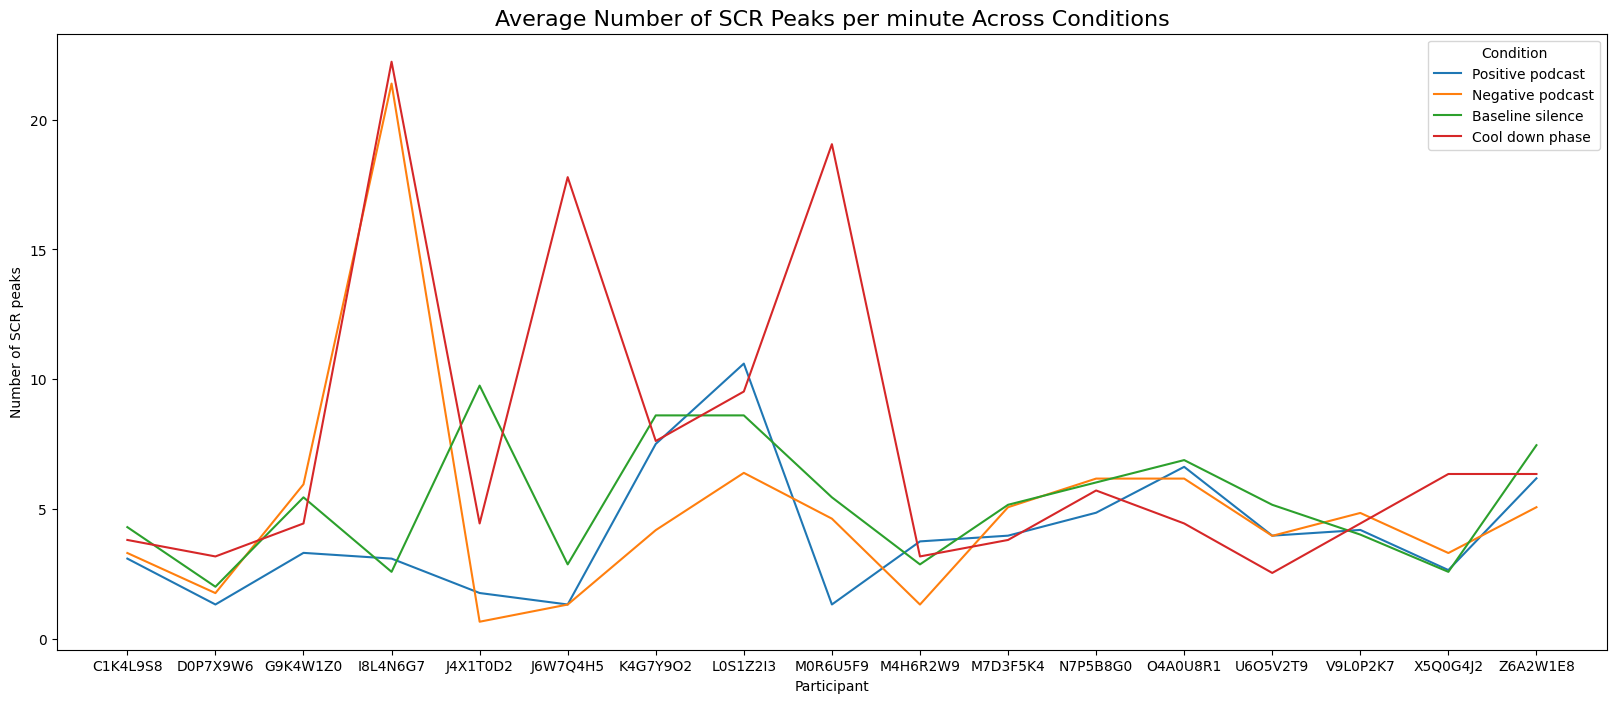

In [168]:
plt.rcParams['figure.figsize'] = [20, 8] 
plt.title("Average Number of SCR Peaks per minute Across Conditions", fontsize=16)
sns.lineplot(data=df, x="Participant", y="Number of SCR peaks", hue="Condition", )
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility
n_participants = len(n_peaks_pos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline silence': n_peaks_bas_1,  
    'Cool down phase': n_peaks_bas_2,  
    'Positive podcast': n_peaks_pos,
    'Negative podcast': n_peaks_neg
}
df = pd.DataFrame(data)


# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

print()


conditions = df.columns[1:]
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        cond1, cond2 = conditions[i], conditions[j]
        stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
        print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}")



Shapiro-Wilk test for Baseline silence: statistic=0.943, p=0.355
Shapiro-Wilk test for Cool down phase: statistic=0.730, p=0.000
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.896, p=0.059
Shapiro-Wilk test for Negative podcast: statistic=0.645, p=0.000
  Negative podcast is not normally distributed (p < 0.05)

Wilcoxon Baseline silence vs Cool down phase: statistic=74.000, p=0.927
Wilcoxon Baseline silence vs Positive podcast: statistic=27.000, p=0.019
Wilcoxon Baseline silence vs Negative podcast: statistic=37.000, p=0.061
Wilcoxon Cool down phase vs Positive podcast: statistic=37.000, p=0.064
Wilcoxon Cool down phase vs Negative podcast: statistic=35.000, p=0.051
Wilcoxon Positive podcast vs Negative podcast: statistic=70.000, p=0.782


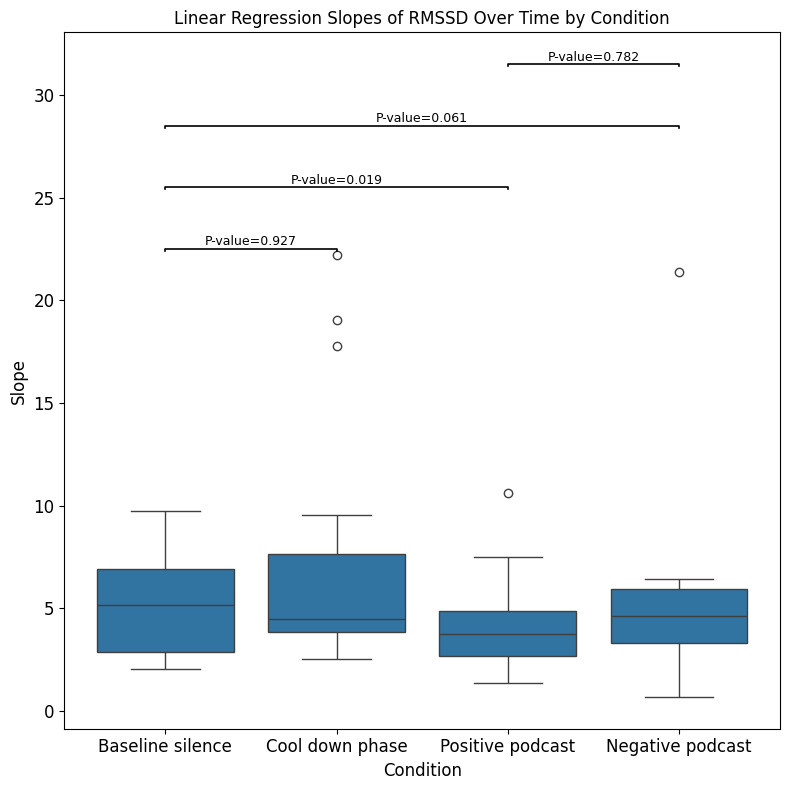

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

plt.rcParams['figure.figsize'] = [10, 5] 

# Melt data to long format
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='SRC_number')

# Initialize plot
plt.figure(figsize=(8, 8))
sns.boxplot(x='Condition', y='SRC_number', data=df_long)


comparisons = [
    ('Baseline silence', 'Cool down phase'),
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
     ('Positive podcast', 'Negative podcast')
]


x_labels = df_long['Condition'].unique().tolist()


y_offset = 3
y_start = df_long['SRC_number'].max() + 0.2  # Leave space above highest point
h = 0.1  # Height of bracket
fontsize = 9


for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # Text label
    label =  f'P-value={round(p_val,3)}'
    plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Number of SCR peaks per minute by Condition', fontsize=12)
plt.ylabel('Number of SCR peaks per minute', fontsize=12)
plt.xlabel('Condition', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


#### Tests for the mean amplitude of peaks

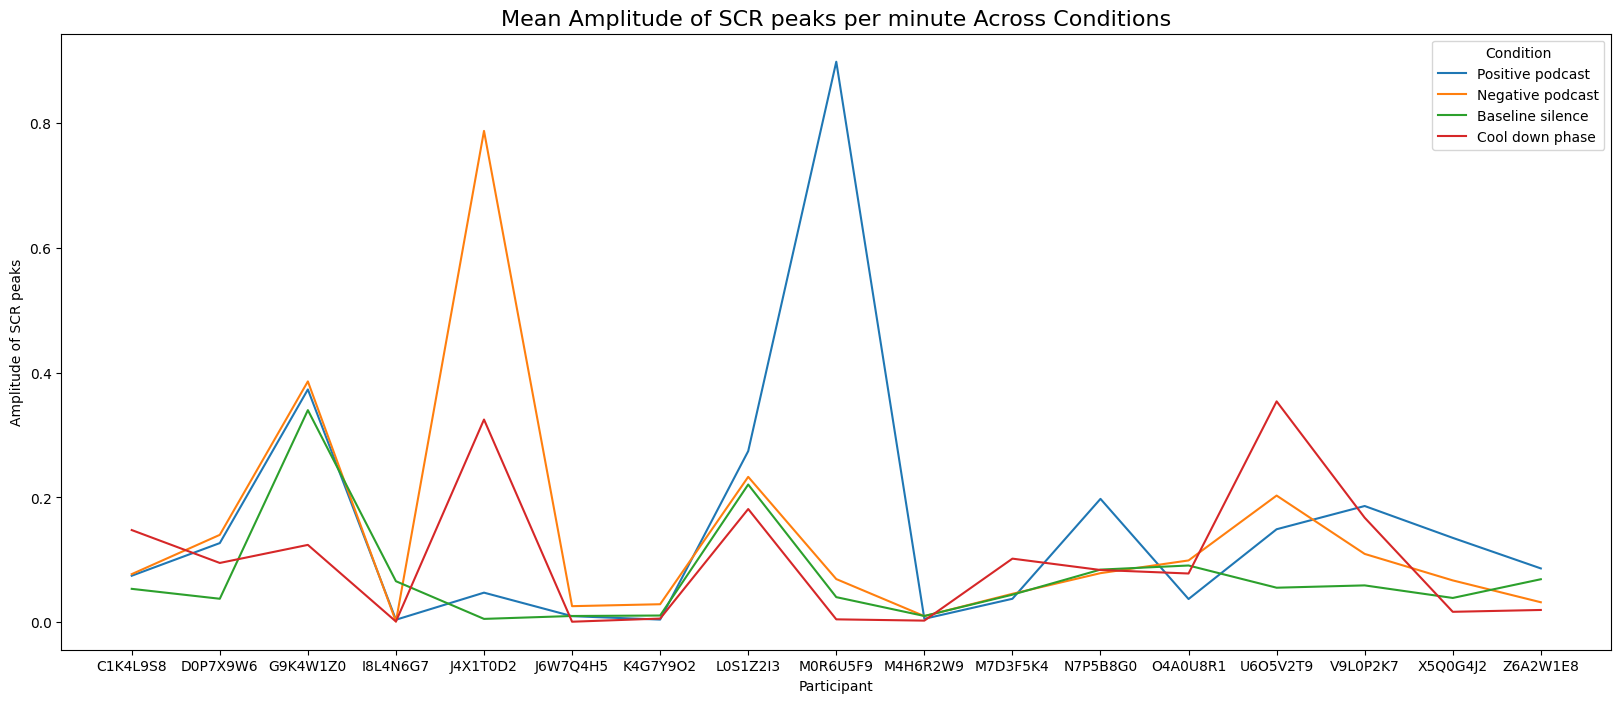

In [234]:
plt.rcParams['figure.figsize'] = [20, 8] 
plt.title("Mean Amplitude of SCR peaks per minute Across Conditions", fontsize=16)
sns.lineplot(data=df, x="Participant", y="Amplitude of SCR peaks", hue="Condition", )
plt.show()

In [235]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility
n_participants = len(ampl_peaks_pos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline silence': ampl_peaks_bas_1,  
    'Cool down phase': ampl_peaks_bas_2,  
    'Positive podcast': ampl_peaks_pos,
    'Negative podcast': ampl_peaks_neg
}
df = pd.DataFrame(data)


# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

print()


conditions = df.columns[1:]
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        cond1, cond2 = conditions[i], conditions[j]
        stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
        print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}")



Shapiro-Wilk test for Baseline silence: statistic=0.680, p=0.000
  Baseline silence is not normally distributed (p < 0.05)
Shapiro-Wilk test for Cool down phase: statistic=0.838, p=0.007
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.673, p=0.000
  Positive podcast is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative podcast: statistic=0.661, p=0.000
  Negative podcast is not normally distributed (p < 0.05)

Wilcoxon Baseline silence vs Cool down phase: statistic=72.000, p=0.854
Wilcoxon Baseline silence vs Positive podcast: statistic=31.000, p=0.031
Wilcoxon Baseline silence vs Negative podcast: statistic=29.000, p=0.023
Wilcoxon Cool down phase vs Positive podcast: statistic=56.000, p=0.353
Wilcoxon Cool down phase vs Negative podcast: statistic=55.000, p=0.329
Wilcoxon Positive podcast vs Negative podcast: statistic=72.000, p=0.854


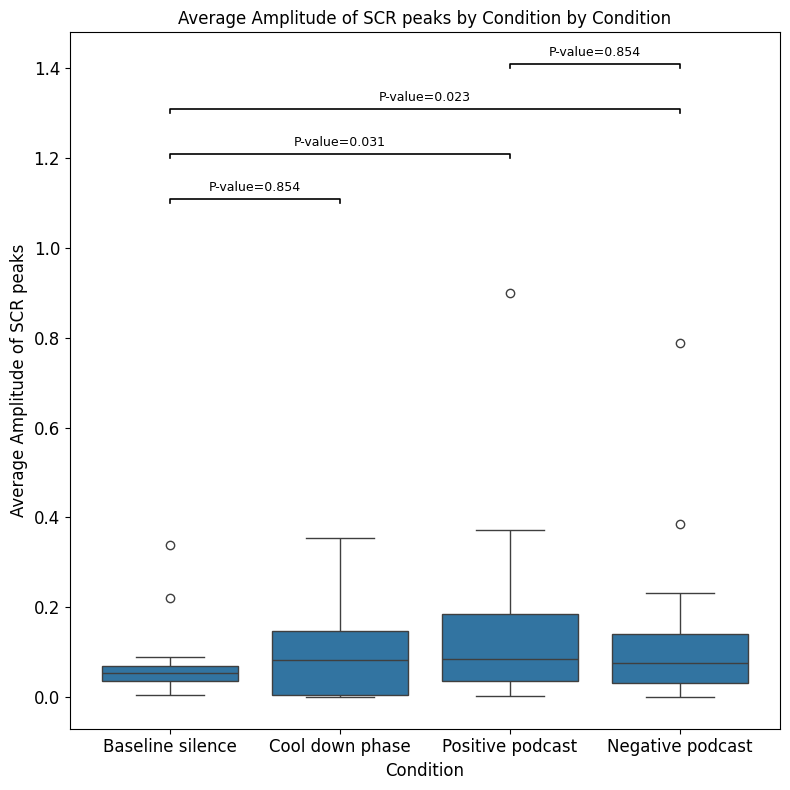

In [239]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

plt.rcParams['figure.figsize'] = [10, 5] 

# Melt data to long format
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='SRC_amplitude')

# Initialize plot
plt.figure(figsize=(8, 8))
sns.boxplot(x='Condition', y='SRC_amplitude', data=df_long)


comparisons = [
    ('Baseline silence', 'Cool down phase'),
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
     ('Positive podcast', 'Negative podcast')
]


x_labels = df_long['Condition'].unique().tolist()


y_offset = 0.1
y_start = df_long['SRC_amplitude'].max() + 0.2  # Leave space above highest point
h = 0.01  # Height of bracket
fontsize = 9


for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # Text label
    label =  f'P-value={round(p_val,3)}'
    plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Average Amplitude of SCR peaks by Condition by Condition', fontsize=12)
plt.ylabel('Average Amplitude of SCR peaks', fontsize=12)
plt.xlabel('Condition', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


# EDA Empatica

## Combine timestamps

In [132]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/Users/annapalatkina/Desktop/drive/stress_output_eda_embracePlus.csv')
problematic = ['R0V9G1L4-3YK3K151PX', 'L1N3B5O2-3YK3K151PX', 'G2Y7J4Q1-3YK3K151PX']
df = df.query('ParticipantID not in @problematic')
df['ParticipantID'].replace('V9LOP2K7-3YK3K151PX', 'V9L0P2K7-3YK3K151PX', inplace=True)

df

,ParticipantID,file_name,samplingFrequencyEDA,time_iso,EDA,detectedMOS,MOS_Score
0,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.171413+00:00,0.101990,0.0,0.0
1,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.421413+00:00,0.127179,0.0,0.0
2,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.671413+00:00,0.132416,0.0,0.0
3,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.921413+00:00,0.134792,0.0,0.0
4,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:55.171413+00:00,0.136614,0.0,0.0
...,...,...,...,...,...,...,...
145051,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.015978+00:00,0.957719,0.0,0.0
145052,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.265978+00:00,0.956452,0.0,0.0
145053,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.515978+00:00,0.954958,0.0,0.0
145054,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.765978+00:00,0.952368,0.0,0.0


In [175]:
def get_experiment_start(path):

    with open(path, 'r+') as f:
        for line in f.readlines():
            if line.startswith('#Recording time'):
                timestamp_str = line.replace('#Recording time,Date: ', '')
                timestamp_str = timestamp_str[:timestamp_str.find(',Unix time:')]
                break

    try:
        ts = pd.to_datetime(timestamp_str,
                        format="%d.%m.%Y,Time: %H:%M:%S.%f +02:00")
    except:
        ts = pd.to_datetime(timestamp_str,
                            format="%m/%d/%Y,Time: %H:%M:%S.%f +02:00")
    ts = ts - timedelta(hours=2)
    nanoseconds = int(ts.value)
    return nanoseconds

In [176]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  

data_full = pd.DataFrame(columns=['miliseconds', 'EDA',  'EventLabel', 'Participant', 'detectedMOS', 'MOS_Score'])

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv') and filename != 'N7P5B8G0.csv': 
        experiment_start_nanoseconds = get_experiment_start(file_path)
        participant_id = filename.split('.')[0]
        data_imotions = pd.read_csv(file_path, comment='#',low_memory=False, usecols=['Row','Timestamp','MarkerName','MarkerType'])
        participant_id_empatica = participant_id + '-3YK3K151PX'
        data_empatica = df.query('ParticipantID == @participant_id_empatica')
        
        data_empatica['miliseconds'] = [(pd.to_datetime(i).value - experiment_start_nanoseconds) / (10**6) for i in data_empatica['time_iso']]
        data_empatica = data_empatica.sort_values(by='miliseconds')

        start = data_imotions.query('MarkerName == "Experiment" and MarkerType == "S"').Timestamp.values[0]
        end = data_imotions.query('MarkerName == "Experiment" and MarkerType == "E"').Timestamp.values[0]
        data_empatica = data_empatica.query('@start <= miliseconds <= @end')

        markers = list(data_imotions[data_imotions['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data_empatica['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "S")].Timestamp.values[0]
            end = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "E")].Timestamp.values[0]
            idx = data_empatica.query('@start <= miliseconds <= @end').index
            data_empatica.loc[idx, 'EventLabel'] = data_empatica.loc[idx, 'EventLabel'].fillna(m)

        #data_empatica['EventLabel'] = data_empatica['EventLabel'].fillna('Silence')
        #data_empatica['Participant'] = [participant_id] * len(data_empatica)
        #data_full = pd.concat([data_full, data_empatica], ignore_index=True)

        non_nan_indices = data_empatica['EventLabel'].notna()
        first_non_nan = non_nan_indices.idxmax() 
        last_non_nan = non_nan_indices[::-1].idxmax()

        data_empatica.loc[:first_non_nan-1, 'EventLabel'] = data_empatica.loc[:first_non_nan-1, 'EventLabel'].fillna('first_silence')
        data_empatica.loc[last_non_nan+1:, 'EventLabel'] = data_empatica.loc[last_non_nan+1:, 'EventLabel'].fillna('last_silence')

        data_empatica.drop(columns=['samplingFrequencyEDA', 'file_name', 'ParticipantID'], inplace=True)
        data_empatica['Participant'] = [participant_id] * len(data_empatica)
        data_full = pd.concat([data_full, data_empatica], ignore_index=True)
        del data_empatica
        gc.collect()

In [177]:
data_full

,miliseconds,EDA,EventLabel,Participant,detectedMOS,MOS_Score,time_iso
0,10656.974,0.183283,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:16.784974+00:00
1,10906.974,0.181575,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:17.034974+00:00
2,11156.974,0.180707,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:17.284974+00:00
3,11406.974,0.180892,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:17.534974+00:00
4,11656.974,0.181561,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:17.784974+00:00
...,...,...,...,...,...,...,...
57417,932538.052,0.007909,last_silence,K4G7Y9O2,0.0,0.00,2025-05-19 09:54:34.822052+00:00
57418,932788.052,0.008236,last_silence,K4G7Y9O2,0.0,0.00,2025-05-19 09:54:35.072052+00:00
57419,933038.052,0.007539,last_silence,K4G7Y9O2,0.0,0.25,2025-05-19 09:54:35.322052+00:00
57420,933288.052,0.008492,last_silence,K4G7Y9O2,0.0,0.00,2025-05-19 09:54:35.572052+00:00


In [178]:
data_full.EventLabel.value_counts()

EventLabel
IntenseAudio     17412
CalmAudio        17382
first_silence    13380
last_silence      6041
InterimAudio      3207
Name: count, dtype: int64

In [179]:
data_full.groupby('Participant').detectedMOS.sum()

Participant
C1K4L9S8     6.0
D0P7X9W6     6.0
G9K4W1Z0     0.0
I8L4N6G7    22.0
J4X1T0D2    26.0
J6W7Q4H5    20.0
K4G7Y9O2    16.0
L0S1Z2I3    11.0
M0R6U5F9    23.0
M4H6R2W9    26.0
M7D3F5K4     4.0
O4A0U8R1     1.0
U6O5V2T9     1.0
V9L0P2K7     8.0
X5Q0G4J2     1.0
Z6A2W1E8    10.0
Name: detectedMOS, dtype: float64

In [180]:
data_full.groupby('Participant').MOS_Score.sum()

Participant
C1K4L9S8     32.50
D0P7X9W6     98.75
G9K4W1Z0     12.00
I8L4N6G7    280.75
J4X1T0D2    531.75
J6W7Q4H5    773.25
K4G7Y9O2    782.25
L0S1Z2I3    259.75
M0R6U5F9    190.50
M4H6R2W9    630.25
M7D3F5K4     12.00
O4A0U8R1    125.50
U6O5V2T9     83.25
V9L0P2K7    351.50
X5Q0G4J2      2.50
Z6A2W1E8     78.00
Name: MOS_Score, dtype: float64

In [181]:
data_full.groupby('EventLabel').detectedMOS.sum()

EventLabel
CalmAudio        50.0
IntenseAudio     57.0
InterimAudio     10.0
first_silence    46.0
last_silence     18.0
Name: detectedMOS, dtype: float64

In [182]:
data_full.groupby('EventLabel').MOS_Score.sum()

EventLabel
CalmAudio        1239.75
IntenseAudio     1282.00
InterimAudio      185.50
first_silence    1099.00
last_silence      438.25
Name: MOS_Score, dtype: float64

In [183]:
sampling_rate = 4

In [184]:
mask_silence_first = (data_full["EventLabel"] == "first_silence")
mask_silence_last = (data_full["EventLabel"] == "last_silence")
mask_negative = (data_full["EventLabel"] == "IntenseAudio")
mask_positive = (data_full["EventLabel"] == "CalmAudio")
mask_music = (data_full["EventLabel"] == "InterimAudio")

In [185]:
positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines_first = data_full[mask_silence_first]
baselines_last = data_full[mask_silence_last]

## Statistical tests for detectedMOS

In [208]:
# Normalize by minutes!!
positives_mos = np.array(positives.groupby('Participant').detectedMOS.sum())/average_time.CalmAudio
negatives_mos = np.array(negatives.groupby('Participant').detectedMOS.sum())/average_time.IntenseAudio
baselines_first = np.array(baselines_first.groupby('Participant').detectedMOS.sum())/average_time.first_silence
baselines_last = np.array(baselines_last.groupby('Participant').detectedMOS.sum())/average_time.last_silence

In [193]:
from scipy.stats import wilcoxon
res = wilcoxon(positives_mos, negatives_mos)
res.statistic, res.pvalue

(np.float64(44.0), np.float64(0.5932539542246835))

In [196]:
t = [i for i, _  in positives.groupby(by='Participant')]

# Create a tidy DataFrame
df = pd.DataFrame({
    "Participant": t * 4,
    "Number of MOS": list(positives_mos) + list(negatives_mos) + list(baselines_first) + list(baselines_last),
    "Condition": ["Positive podcast"] * len(t) + ["Negative podcast"] * len(t) + ["Baseline silence"] * len(t) + ["Cool down phase"] * len(t)
})

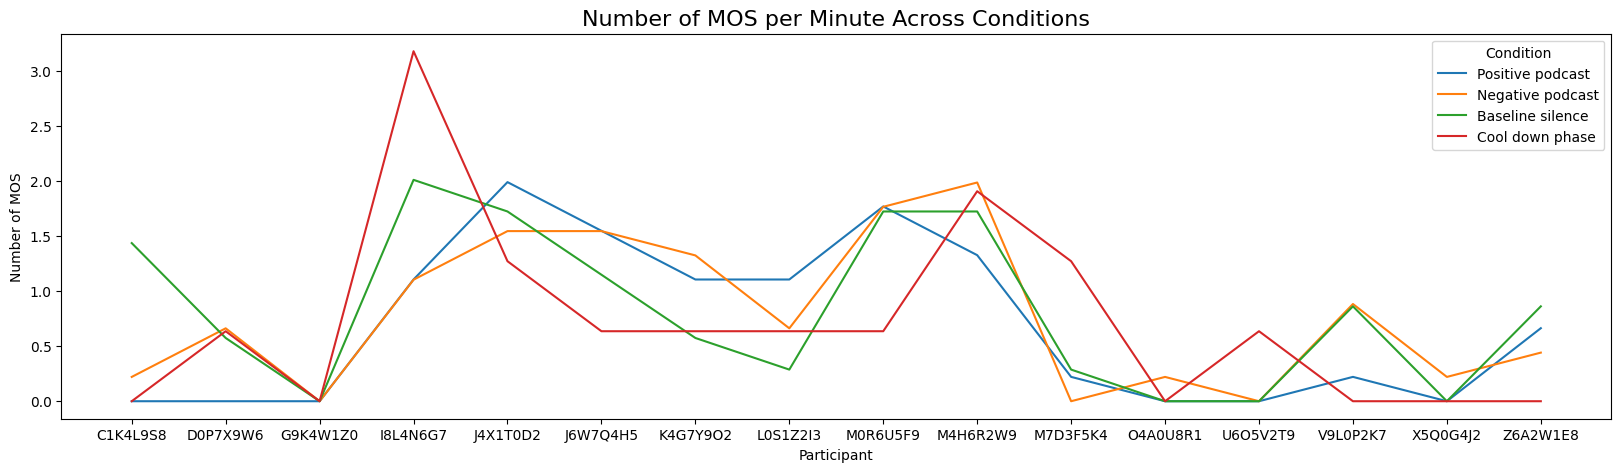

In [197]:
plt.rcParams['figure.figsize'] = [20, 5] 
plt.title("Number of MOS per Minute Across Conditions", fontsize=16)
sns.lineplot(data=df, x="Participant", y="Number of MOS", hue="Condition")
plt.show()

In [ ]:
np.random.seed(42)  # For reproducibility
n_participants = len(positives_mos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline silence': baselines_first,  
    'Cool down phase': baselines_last, 
    'Positive podcast': positives_mos,
    'Negative podcast': negatives_mos
}
df = pd.DataFrame(data)

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

Shapiro-Wilk test for Baseline silence: statistic=0.893, p=0.061
Shapiro-Wilk test for Cool down phase: statistic=0.780, p=0.001
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.844, p=0.011
  Positive podcast is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative podcast: statistic=0.908, p=0.110


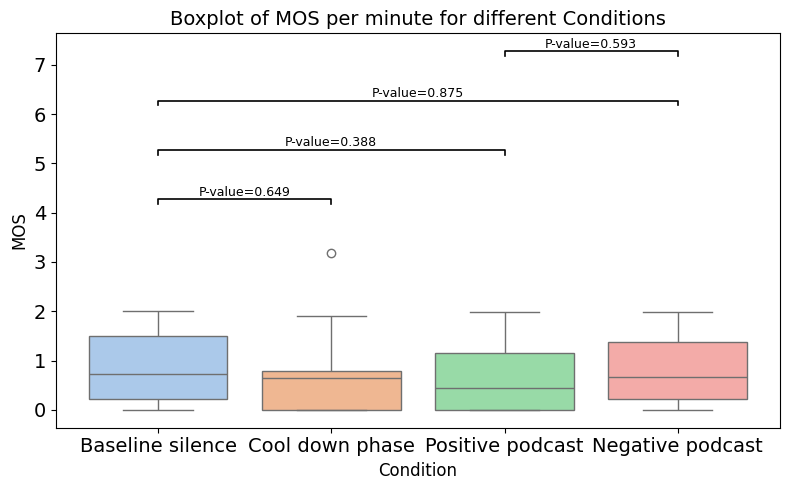

In [203]:


# Melt data to long format
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='MOS')

# Initialize plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Condition', y='MOS', data=df_long, palette='pastel')


comparisons = [
    ('Baseline silence', 'Cool down phase'),
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
     ('Positive podcast', 'Negative podcast')
]


x_labels = df_long['Condition'].unique().tolist()


y_offset = 1
y_start = df_long['MOS'].max() + 1  # Leave space above highest point
h = 0.1  # Height of bracket
fontsize = 9


for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # Text label
    label =  f'P-value={round(p_val,3)}'
    plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Boxplot of MOS per minute for different Conditions', fontsize=14)
plt.ylabel('MOS', fontsize=12)
plt.xlabel('Condition', fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


## Statistical tests for MOS_score

In [209]:
positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines_first = data_full[mask_silence_first]
baselines_last = data_full[mask_silence_last]

In [210]:
positives_mos = np.array(positives.groupby('Participant').MOS_Score.mean())
negatives_mos = np.array(negatives.groupby('Participant').MOS_Score.mean())
baselines_first = np.array(baselines_first.groupby('Participant').MOS_Score.mean())
baselines_last = np.array(baselines_last.groupby('Participant').MOS_Score.mean())

In [212]:
from scipy.stats import wilcoxon
res = wilcoxon(positives_mos, negatives_mos)
res.statistic, res.pvalue

(np.float64(47.0), np.float64(0.2978515625))

In [213]:
t = [i for i, _  in positives.groupby(by='Participant')]

# Create a tidy DataFrame
df = pd.DataFrame({
    "Participant": t * 4,
    "Mean MOS score": list(positives_mos) + list(negatives_mos) + list(baselines_first) + list(baselines_last),
    "Condition": ["Positive podcast"] * len(t) + ["Negative podcast"] * len(t) + ["Baseline silence"] * len(t) + ["Cool down phase"] * len(t)
})

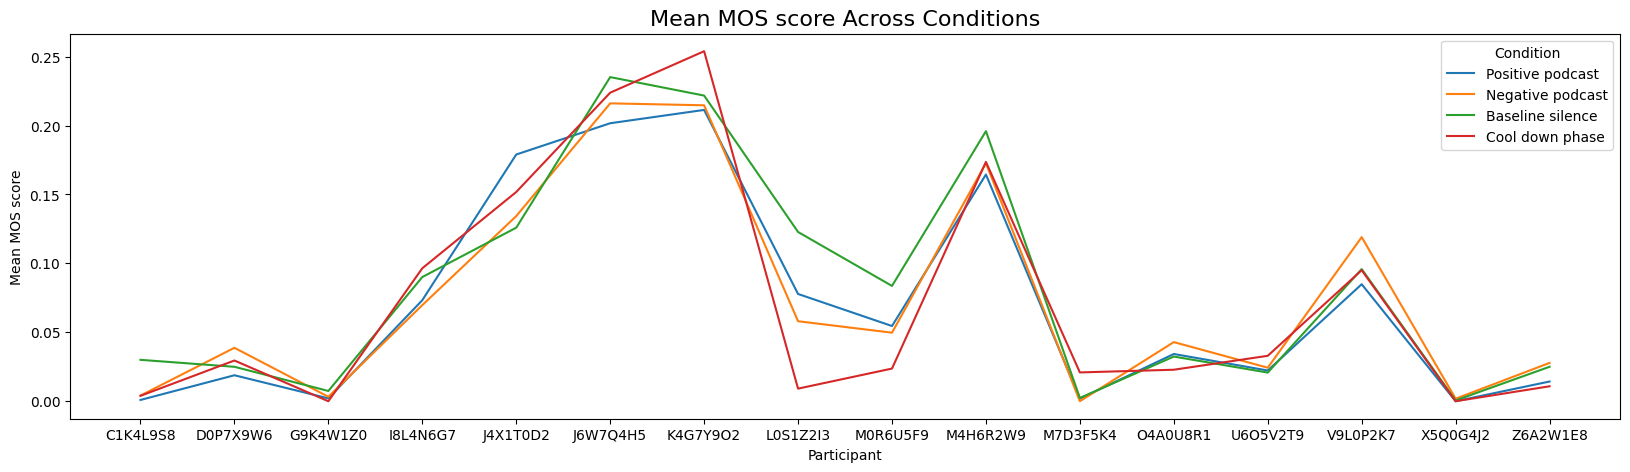

In [215]:
plt.rcParams['figure.figsize'] = [20, 5] 
plt.title("Mean MOS score Across Conditions", fontsize=16)
sns.lineplot(data=df, x="Participant", y="Mean MOS score", hue="Condition")
plt.show()

In [216]:
np.random.seed(42)  # For reproducibility
n_participants = len(positives_mos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline silence': baselines_first,  
    'Cool down phase': baselines_last, 
    'Positive podcast': positives_mos,
    'Negative podcast': negatives_mos
}
df = pd.DataFrame(data)

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

Shapiro-Wilk test for Baseline silence: statistic=0.863, p=0.022
  Baseline silence is not normally distributed (p < 0.05)
Shapiro-Wilk test for Cool down phase: statistic=0.800, p=0.003
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.831, p=0.007
  Positive podcast is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative podcast: statistic=0.849, p=0.013
  Negative podcast is not normally distributed (p < 0.05)


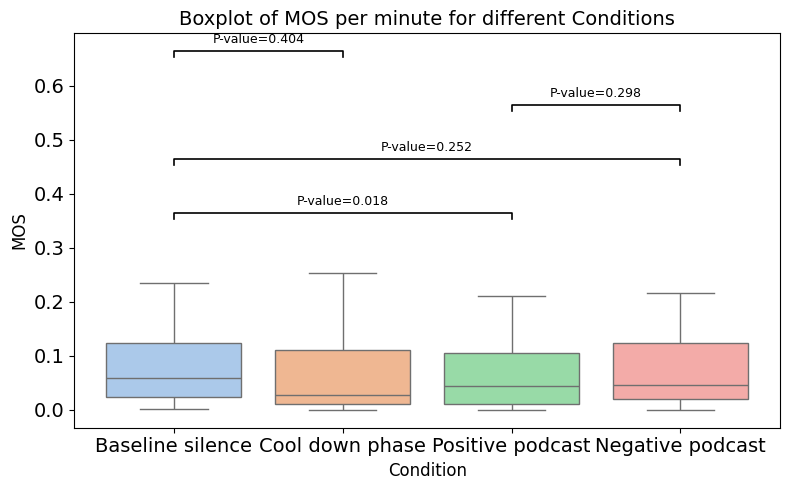

In [227]:


# Melt data to long format
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='MOS')

# Initialize plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Condition', y='MOS', data=df_long, palette='pastel')


comparisons = [
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
     ('Positive podcast', 'Negative podcast'),
     ('Baseline silence', 'Cool down phase')
]


x_labels = df_long['Condition'].unique().tolist()


y_offset = 0.1
y_start = df_long['MOS'].max() + 0.1  # Leave space above highest point
h = 0.01  # Height of bracket
fontsize = 9


for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # Text label
    label =  f'P-value={round(p_val,3)}'
    plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Boxplot of MOS per minute for different Conditions', fontsize=14)
plt.ylabel('MOS', fontsize=12)
plt.xlabel('Condition', fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()
